# Welcome to the accelerate python code tutorial

## This notebook has a pdf

This notebook also comes with its own pdf. You can use this pdf as a last-resort tool, when python simply won't work. The very bottom of this notebook contains some instructions for converting this notebook to pdf.

## Setting up the environment

Let's check if you have cython installed. For this, try to execute the next cell.

In [35]:
from Cython.Build import cythonize

If this cell executes fine, you are good to go. If it says something like 'no module named Cython', we need to get it somehow. For this I prepared a portable python deployment with all the packages you need. Here's how to use it:

1) Make sure you are not inside another virtual environment. If your prompt has something in parentheses preceding it, like (base) in this example:

```bash
(base) kevin@pccp18:~$
```

deactivate the environment with these two commands. One of them should work.

```bash
$ conda deactivate
$ source deactivate
```

2) Source the virtual environment from this repository.

```bash
$ source /path/to/repo/venv/bin/activate
```

3) Confirm if this has worked with these two commands:

```bash
$ which python
> /path/to/repo/bin/python
$ python --version
> 3.7.something
```

4) Close this notebook server and open this notebook with the new virtual environment. by calling:

```bash
$ jupyter-notebook cython_workshop.ipynb
```

## Setting autoreload

Importing some pre-compiled cython files is similar to importing regular python files. They get appended to the current namespace and stay there even if you change the file or reload it. Let us use the autreload magic to fix that issue.

In [134]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Cython. It's compiled python.

Cython is aimed to be a superset to the python programming language. Cython is a compiled language with python-like syntax. You can write cython files (.pyx) files in a similar manner than you would write normal python files (.py), compile them and import the generated shared object (.so) as a module into your python code. Doing this allows you to greatly decrease the computational overhead at run time, i.e. make python faster. You may find the best use in cython if you use it to compile specific computationally-heavy functions.

## The compilation pipeline

Cython is always compiled in two steps.

- The cython compiler transforms cython code (.pyx) into optimized and platform-independent C or C++ code (.c).
- A standard compiler compiles the C code (.c) into a shared object (.so) which can be imported to python.

The shared object is platform specific (architecture and OS). Someone running the very niche Windows 10 for ARM will face some difficulties using your .so file. On windows these files also get a different extension (.pyd). After we get this sorted out we will look at how to write and compile cython.

## Compilation

There are several ways you can utilize to get your cython code compiled and imported into python. Because we work with jupyter notebooks and the people from jupyter have added the nice %%cython cell magic we will use this convenient way to compile cython code. Simply add `%%cython` at the top of your cells and you're good to go.

(The other compilation methods are further down in this notebook)

In [135]:
%load_ext Cython

The %%cython cell magic comes with its own options, you can check out here:

https://ipython.org/ipython-doc/2/config/extensions/cythonmagic.html

In [ ]:
%%cython
def fibonacci(int n):
    cdef int i
    cdef double a=0.0, b=1.0
    for i in range(n):
        a, b = a+b, a
    return a

In [ ]:
fibonacci(20)

The compiled file can be found in ~/.ipython/cython

# Going through some projects

I think the easiest way to get into cython is to look at some examples. We will write some code in python, port it to cython and make further adjustments to increase speeds. I'll walk you through it.

## Factorials

To really see how cython can speed up your calculations we need some really difficult to compute stuff. Let's get started with factorials! Here's a pure python implementation of a function which calculates the factorial of the provided input.

### Pure python

In [57]:
def fact(n):
    """Computes factorial."""
    if n <= 1:
        return 1
    return n * fact(n - 1)

In [58]:
print(fact(4))

24


In [60]:
%timeit fact(20)

2.53 µs ± 14.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


For me, it took 2.53 µs to calculate the factorial of 20. To make this computation faster we can directly port this function to cython.

### Cython

In [24]:
%load_ext cython

In [87]:
%%cython

def fact_cy(n):
    """Also computes factorial."""
    if n <= 1:
        return 1
    return n * fact_cy(n - 1)

In [88]:
%timeit fact_cy(20)

833 ns ± 8.52 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


For me, it took 848 ns on average to calculate the factorial of 20. This is a pretty nice speedup and it is achieved by simply putting `%%cython` at the start of the cell.

### Cython with static typing

Further speedup will be achieved by telling cython what datatype your variables are going to be. Cython will optimize the C code depending on what types you are using. For static type declaration you have to adjust the syntax of your functions.

- The input type will be declared in the parentheses of the function declaration.
```cython
def func_namme(int i, long n, double a):
    # ...
```
Here, the datatypes of C need to be used. `long` is a long signed integer, `double` is a double precision floating point value. For more C types there's a wikipedia article about it: https://en.wikipedia.org/wiki/C_data_types

- Types of variables used in the function body will be declared with the `cdef` statement

```cython
def some_func():
    cdef int i, n=20
    cdef float z=2.4e-10
```

If we change the syntax of our code like this, it will no longer be executable in python.

In [97]:
%%cython

def fact_cy_static(long n):
    """Also computes factorial."""
    if n <= 1:
        return 1
    return n * fact_cy_static(n - 1)

In [95]:
%timeit fact_cy_static(20)

665 ns ± 0.817 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


For me it took 665 ns on average.

### Static functions

The functions in cython itself can also be statically typed with the `cdef` statement. This will grant us further speedup, because the code will be optimized by statically defining the return type of the function. To statically define a cython function use this syntax:

```cython
cdef double func_name(int i, double z):
    # ...
```

There's a minor draw-back when using static functions: These functions can't return something python can use. We need to wrap these static functions with a more dynamic python function. A simple dynamic defined wrapping function, calling the static function, is oftentimes sufficient.

In [98]:
%%cython
cdef long c_fact(long n):
    """Computes factorial very fast."""
    if n <= 1:
        return 1
    return n * c_fact(n - 1)

def wrap_c_fact(n):
    return c_fact(n)

In [100]:
%timeit wrap_c_fact(20)

68.6 ns ± 0.193 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


For me it took 68.6 ns on average. Quite the significant speedup. But we can go even faster.

### The fastest factorial

**By removing the recursion from this script, we are at the limit.**

In [101]:
%%cython
cdef long c_fact_no_rec(long n):
    """Computes factorial very fast."""
    cdef float fact
    cdef long i
    for i in range(n + 1):
        if i <= 1:
            fact *= 1
        fact *= i

def wrap_c_fact_no_rec(n):
    return c_fact_no_rec(n)

In [102]:
%timeit wrap_c_fact_no_rec(20)

37.1 ns ± 0.283 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


For me it took 37.1 ns on average. Quite the speedup coming from 2.53 µs.

## LJ simulation

Here's a LJ simulation I wrote. Let's evaluate its performance and then try to part it to cython.

In [151]:
import numpy as np
import time
from scipy.stats import maxwell as scipy_maxwell
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook
    
class Parameters:
    # Simulation parameters/constants 
    kb = 1.380e-23 # Boltzmann (J/K)
    Nav = 6.022e23 # Avogadro (/mol)
    m = (39.95/Nav)*(10**-3) # atomic mass unit (kg)
    epsilon = kb*120 # depth of potential well (J/K)
    sigma = 3.4e-10 # sigma in Lennard-Jones Potential (m)
    rcut = 2.25*sigma # Cutoff radius, (m)
    rcutsq = rcut**2 # Square of the cutoff radius, (m^2)
    def __init__(self):
        pass
    
    def __getitem__(self, item):
        return getattr(self, item)
    
class LJ:
    def __init__(self):
        params = Parameters()
        epsilon = params['epsilon']
        sigma = params['sigma']
        self.potential = lambda x: 4 * epsilon * ((sigma/x)**12 - (sigma/x)**6)
        self.lj_force = lambda x: 24 * epsilon / x * ((2*(sigma / x)**12) - (sigma / x)**7)

class State:
    """The current state of a simple LJ simulation.
    
    This is a python-implementation using numpy. It also contains a plotting tool
    which allows visualization of 2D simulations. The numpy-optimized cython version
    follows soon. The code ist not very optimized, especially force calculations. This
    can greatly be accleerated by C for loops. Furthermore the LJ and Box classes
    could also be implemented in this class. I specificially expunged them from this class
    to also demonstrate 'cython libraries', where pieces of cython code access other cython
    code from different files.
    
    Todo:
        * Write a Maxwell-Boltzmann distribution. It is basically a chi
            distribution with specific parameters. See this link for more info:
            https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.boltzmann.html
            
    Attributes:
        n_particles (int): The number of particles in the system.
        dim (int): The dimension of your system. Only 2 and 3 makes sense, really.
        dt (float): The timestep in femtoseconds (fs).
        frame (int): At what frame the state is currently.
        time (float): The time the state is currently. time == dt * frame
        nstlist (int): If frame % nstlist == 0, the neighbor-list will be updated.
        cutoff (flaot): The cutoff for neighbor-searching. Defaults to 2 * sigma, 7.14e-10.
        neighbor_list (list): List containing [i, j, dist] lists, which give the indices and
            the distance of neighbors.
        temp (float): The current temperature of the system.
        masses (np.ndarray): The masses of the atoms. Most often an array of 40 amu for Argon.
        positions (np.ndarray): The positions of your atoms. positions.shape == (n_particles, dim)
        velocities (np.ndarray): The velocities.
        accelerations (np.array): The accelerations.
        momenta (np.array): The momenta of the particles.
        forces (np.ndarray): The forces of the system. This array has a special formatting.
            forces[:,0] is the index of the first atom, forces[:,1] is the index of the
            second atom. forces[:,2:] are the directional components of this force (based on
            how many dimensions the state has).
        potentials (np.ndarray): The potentials of the system. This array has a special formatting.
            potentials[:,0] is the index of the first atom, potentials[:,1] is the index of the
            second atom. potentials[:,2:] are the directional components of this potential (based on
            how many dimensions the state has).
        self.pot_energy (float): The current potential energy.
        self.kin_energy (float): The current kinetic energy.
        self.tot_energy (float): The current total energy.
        
    """
    def __init__(self, positions, velocities='random', masses=None, nststep=5, dt=0.02,
                 temp=273, cutoff=7.14e-10, boundaries=100e-10):
        """Initializes the State class and prepares the initial state of the sim.
        
        Args:
            positions (np.ndarray): The positions of your atoms. 2D or 3D or even more.
            
        Keyworded Args:
            velocities (np.ndarray/str): The initial velocities of your atoms. Can be
                a numpy array of velocities. Can be 'random', or 'boltzmann', depending
                on how you would like to generate starting velocities. Defaults to
                'random'.
            masses (np.ndarray): The masses of your atoms. If not provided all
                atoms will be set to have the mass of Argon. Defaults to None.
            nststep (int): How often the neighbor list will be updated. Defaults to 5.
            dt (int): The integrator step in fs. Defaults to 0.02.
            temp (float): The goal temperature in Kelvin. Defaults to 273.
            cutoff (float): The cutoff for neighbor-searching. Defaults to 2 * sigma, 7.14e-10.
            bondaries (float): The max/min value of the simulation box in m.
                The box is centered on the coordinate origin. Defaults to 100e-10.
            
        Raises:
            AssertionError: If the provided arrays are misaligned.
        
        """
        # get some initial info
        self.positions = positions
        self.n_particles, self.dim = self.positions.shape
        self.save_positions = self.positions.reshape(1, self.n_particles, self.dim)
        self.dt = dt
        self.temp = temp
        self.nststep = nststep
        self.cutoff = cutoff
        self.boundaries = boundaries
        # masses and velocities check and set
        if not np.any(masses):
            self.masses = np.full(self.n_particles, 40 * Parameters.m) # 40 amu is the mass of argon
        self.velocities = velocities
        self.momenta = np.multiply(self.masses[:, np.newaxis], self.velocities)
        
        # some sub-classes
        self.lj = LJ()

        # initial state descriptors
        self.time = 0
        self.frame = 0
        self.dt = dt * 1e-15
        
        # initial force, energy, temperature and neighbors calculation
        self.forces, self.accelerations, self.potentials = self.calc_pot_force_accel(self.positions, self.masses, self.lj.potential, self.lj.lj_force)
        self._calc_energy_and_temp()
        
        # check whether positions and velocities are correcly shaped
        assert self.positions.shape == self.velocities.shape
        
        # the propagation is handled by a generator found in self._propagate()
        self.traj = self._propagate()
        
    @property
    def velocities(self):
        return self.__velocities
    
    @velocities.setter
    def velocities(self, velocities):
        if velocities == 'random':
            self.__velocities = (np.random.rand(self.n_particles, self.dim) * 20 - 10) * 5
        elif velocities == 'boltzmann':
            self.__velocities = self.get_vel_from_boltzmann(self.positions.shape, self.temp)
        elif isinstance(velocities, np.ndarray):
            self.__velocities = velocities
        else:
            raise Exception("Argument velocitites takes np.ndarray, 'random' or 'boltzmann', "
                          f"You provided {velocities}")
            
    @staticmethod
    def pbc(pos, boundaries):
        for d in range(pos.shape[1]):
            upper_bound = boundaries
            lower_bound = - boundaries
            tmp_pos = pos[:, d] - upper_bound
            upper_atoms = np.where(tmp_pos > 0)
            pos[upper_atoms, d] -= (upper_bound-lower_bound)
            del tmp_pos, upper_atoms
            tmp_pos = lower_bound - pos[:, d]
            lower_atoms = np.where(tmp_pos > 0)
            pos[lower_atoms, d] += (upper_bound-lower_bound)
            del tmp_pos, lower_atoms
            del upper_bound, lower_bound
        return pos
    
    @staticmethod
    def get_vel_from_boltzmann(shape, temp):
        """Returns random velocities given by a Maxwell-Boltzmann distribution."""
        scaling_factor = np.sqrt(Parameters.kb*temp/Parameters.m)
        # return np.random.normal(0, 1, shape) * scaling_factor # this returns a normal, which is approximately fine
        directions = np.vstack([d / np.linalg.norm(d) for d in np.random.rand(*shape)])
        velocities = directions * scipy_maxwell.rvs(loc=0, scale=temp, size=shape[0]).reshape(shape[0], 1)
        return velocities
    
    @staticmethod
    def calc_pot_force_accel(positions, masses, pot_func, force_func, nstlist=False):
        """Calculates forces, accelerations and Potentials."""
        if np.any(nstlist):
            forces = []
            potentials = []
            n_particles = positions.shape[0]
            accelerations = np.zeros(positions.shape)
            for item in nstlist:
                i, j = item[:2].astype(int)
                dist = item[2]
                r = item[3:]
                if not dist:
                    # dist needs new calculation
                    r = positions[i] - positions[j]
                    dist = np.linalg.norm(r)
                # now calculate forces and the other shenanigans
                force = force_func(dist) * r
                pot = pot_func(dist)
                forces.append([i, j, *force])
                potentials.append([i, j, pot])
                accelerations[i] += force / masses[i]
                accelerations[j] -= force / masses[j]
            forces = np.array(forces)
            potentials = np.array(potentials)
            return forces, accelerations, potentials
        else:
            forces = []
            potentials = []
            n_particles = positions.shape[0]
            accelerations = np.zeros(positions.shape)
            for i in range(n_particles):
                for j in range(n_particles):
                    if i >= j:
                        continue
                    r = positions[i] - positions[j]
                    dist = np.linalg.norm(r)
                    force = force_func(dist) * r
                    pot = pot_func(dist)
                    forces.append([i, j, *force])
                    potentials.append([i, j, pot])
                    accelerations[i] += force / masses[i]
                    accelerations[j] -= force / masses[j]
            forces = np.array(forces)
            potentials = np.array(potentials)
            return forces, accelerations, potentials
        
    def _propagate(self):
        """Uses generator to propagate the state."""
        pos = self.positions
        forces = self.forces
        velocities = self.velocities
        accelerations = self.accelerations
        potentials = self.potentials
        t = self.time
        f = self.frame
        while True:
            pos = self.pbc(pos + self.velocities * self.dt + 0.5 * self.accelerations * self.dt ** 2, self.boundaries)
            # only update the velocities where the accelerations are not euqal to zero.
            # Otherwise keep the velocities constant
            index = np.mean(self.accelerations, axis=1) != 0
            if np.any(~index):
                print(accelerations)
            velocities[index] = accelerations[index] * self.dt
            forces, accelerations, potentials= self.calc_pot_force_accel(pos,
                                                                         self.masses,
                                                                         self.lj.potential,
                                                                         self.lj.lj_force,
                                                                         nstlist=self.neighbor_list)
            t += self.dt
            f += 1
            yield pos, velocities, accelerations, forces, potentials, t, f
            
    def _update_plot(self, i):
        """Calls the _propagate generator and updates the scatter plot self.scat"""
        data, velocities, accelerations, forces, potentials, t, f = next(self.traj)
        # Set x and y data...
        self.scat.set_offsets(data)
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
        
    def _plot(self):
        """Initial drawing of the scatter plot."""
        pos, velocities, accelerations, forces, potentials, t, f = next(self.traj)
        self.scat = self.ax.scatter(*pos.T, s=150, edgecolor="k")
        self.ax.axis([-self.boundaries, self.boundaries, -self.boundaries, self.boundaries])
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    
    def _calc_energy_and_temp(self):
        """Calcs current energty and temp."""
        self.pot_energy = self.potentials[:,2].sum()
        self.kin_energy = (0.5 * self.masses * np.linalg.norm(self.velocities, axis=1) ** 2).sum()
        self.tot_energy = self.pot_energy + self.kin_energy
        self.temp = self.kin_energy * 2 / (Parameters.kb * (self.dim * self.n_particles - self.dim))
        
    def _find_neighbors(self):
        """Calculates the distances between particles and updates the neighbor list"""
        self.neighbor_list = []
        for i in range(self.n_particles):
            for j in range(self.n_particles):
                if i >= j:
                    continue
                r = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(r)
                if dist <= self.cutoff:
                    self.neighbor_list.append([i, j, dist, *r])
        self.neighbor_list = np.array(self.neighbor_list)
            
    def update(self):
        """Calls next item from the _propagate generator."""
        if self.frame % self.nststep == 0:
            self._find_neighbors()
            (self.positions,
             self.velocities,
             self.accelerations,
             self.forces,
             self.potentials,
             self.time,
             self.frame) = next(self.traj)
        else:
            self.neighbor_list[:,2] = 0
            (self.positions,
             self.velocities,
             self.accelerations,
             self.forces,
             self.potentials,
             self.time,
             self.frame) = next(self.traj)
        self._calc_energy_and_temp()
            
    def run_with_plot(self):
        """Runs the sim and plots stuff."""
        self.neighbor_list = False
        self.fig, self.ax = plt.subplots()
        self.ani = animation.FuncAnimation(self.fig, func=self._update_plot,
                                           interval=5, init_func=self._plot, blit=True)
        
    def plot_current_state(self):
        """Simple scatter plot of the particles in the current system."""
        fig, ax = plt.subplots()
        ax.axis([-self.boundaries, self.boundaries, -self.boundaries, self.boundaries])
        ax.scatter(*self.positions.T, s=150, edgecolor="k")
        
    def print_current_state(self):
        """Prints a longer string, intended as a log."""
        s = ''
        s += f"Simulation contains {self.n_particles} particles in {self.dim} dimensions.\n"
        s += f"We are at frame {self.frame} at cumulated {self.time} fs.\n"
        s += f"Current Kinetic Energy is {self.kin_energy} J, Potential Energy is {self.pot_energy} J, Temperature is {self.temp} K.\n"
        s += f"The Box is cubic and expands to {self.boundaries} m."
        print(s)
        
    def _build_str(self):
        """Is calles by the __str__ and __repr__ methods. Prints info about the object."""
        s = ''
        s += f"Simulation at frame {self.frame} with {self.n_particles} particles"
        return s
    
    def __str__(self):
        return f"<{self._build_str()}>"
    
    def __repr__(self):
        return f"<{self._build_str()} at 0x{id(self):02x}>"

We initialize the simulation with 100 particles in 2D (100, 2) which will be placed between -10 and 10 nm on both, the x and y axis.

In [99]:
np.random.seed(1)
positions = (np.random.rand(100, 2) * 20 - 10) * 1e-10
# due to the large integrator step of 1000fs, neighbors will be calculated every step
sim = State(positions, velocities='boltzmann', dt=1, nststep=5, boundaries=10e-10)
print(sim)

<Simulation at frame 0 with 100 particles>


The simulation class also comes with some animation we can take a look at.

<IPython.core.display.Javascript object>


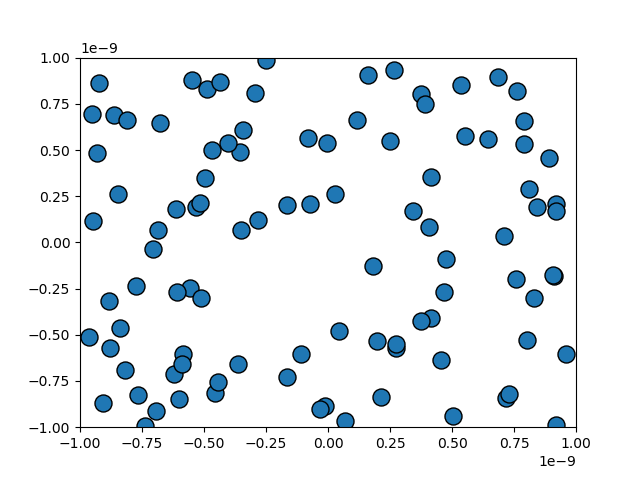

In [407]:
sim.run_with_plot()

In [409]:
plt.close('all')

Some particles might be really fast, because they started very close to each other. To evaluate the performance of this code, we let it iterate for some time and count how long it took. Let us add some more particles and a third dimension.

In [152]:
np.random.seed(1)
positions = (np.random.rand(250, 3) * 20 - 10) * 1e-10
# due to the large integrator step of 1000fs, neighbors will be calculated every step
sim = State(positions, velocities='boltzmann', dt=1, nststep=5, boundaries=10e-10)

def run(State, n_steps, silent=True):
    """Propagates a State for n_steps"""
    if not silent: print(State.frame, State.positions[0], State.velocities[0])
    for i in range(n_steps):
        State.update()
        if not silent: print(State.frame, State.positions[0], State.velocities[0])

In [153]:
%time run(sim, 50)

/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


CPU times: user 5.39 s, sys: 248 ms, total: 5.64 s
Wall time: 5.35 s


For me, it took 5.1 seconds for the run to complete.

Let's port this function to cython with what we have learned and some additional stuff regarding NumPy in cython. Here's how we are going to do it.

1) Remove all matplotlib functions from the class. As expected, cython doesn't really work with matplotlib.

2) Move the calc_pot_force_accel() function to cython

3) move the get_neighbors() function to cython.

4) Try to move as much stuff as possible to cython.

In [3]:
import numpy as np
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


### Move the force and acceleration calculation to cython

Because cython functions are faster, when the return type is already defined (i.e. `cdef long func_name`) we will only return the acceleration from this function. To compare the speeds here's the pythoin implementation.

In [6]:
positions = (np.random.rand(250, 3) * 20 - 10) * 1e-10
masses = np.full(positions.shape[0], 40 * Parameters.m) # 40 amu is the mass of argon
lj = LJ()

In [7]:
%timeit f, a, p = State.calc_pot_force_accel(positions, masses, lj.potential, lj.lj_force, nstlist=False)

478 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


574 ms for me. Here's the cython implementation. It starts with the static declaration of the constants and two C functions calculating potential and force. 

In [85]:
%%cython
import numpy as np
cimport numpy as np

cdef:
    double kb = 1.380e-23
    double epsilon = kb * 120
    double sigma = 3.4e-10

# write a nice fast C function for force calucaltion
cdef double force_calc(double dist):
    cdef double force
    force = 24 * epsilon / dist * ((2*(sigma / dist)**12) - (sigma / dist)**7)
    return force
# write a nice fast C function for potential calculation
cdef double pot_calc(double dist):
    cdef double pot
    pot = 4 * epsilon * ((sigma/dist)**12 - (sigma/dist)**6)
    return pot

cpdef np.ndarray[double, ndim=2] calc_accel_cy(np.ndarray[double, ndim=2] positions,
                                                     np.ndarray[double, ndim=1] masses,
                                                     list nstlist = [0]):
    cdef:
        int n_particles = len(positions)   
        int ndim = len(positions[0])
        np.ndarray[double, ndim=1] force
        np.ndarray[double, ndim=1] pot
        np.ndarray[double, ndim=2] accelerations = np.zeros((n_particles, ndim))
        np.ndarray[double, ndim=1] r
        double dist
        int k
        int max_iter = len(nstlist)
        int i, j
    if any(nstlist):
        for k in range(max_iter):
            i, j = nstlist[k][:2]
            dist = nstlist[k][2]
            r = np.array(nstlist[k][3:])
            force = r * force_calc(dist)
            accelerations[i] += force / masses[i]
            accelerations[j] -= force / masses[j]
    else:
        for i in range(n_particles):
            for j in range(n_particles):
                if i >= j:
                    continue
                r = positions[i] - positions[j]
                dist = np.linalg.norm(r)
                force = r * force_calc(dist)
                accelerations[i] += force / masses[i]
                accelerations[j] -= force / masses[j]
    return accelerations

In [80]:
positions = (np.random.rand(250, 3) * 20 - 10) * 1e-10
masses = np.full(positions.shape[0], 40 * Parameters.m) # 40 amu is the mass of argon

In [81]:
%timeit acc = calc_accel_cy(positions, masses)

379 ms ± 34.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


313 ms for me. Let's continue with

### Move the neighborlist calculation to cython

In [66]:
%%cython
import numpy as np
cimport numpy as np

cpdef list find_neighbors_cy(np.ndarray[double, ndim=2] positions, double cutoff):
    cdef:
        int n_particles = len(positions)   
        int ndim = len(positions[0])
        list nstlist = []
        
    for i in range(n_particles):
        for j in range(n_particles):
            if i >= j:
                continue
            r = positions[i] - positions[j]
            dist = np.linalg.norm(r)
            if dist <= cutoff:
                if i == 0 and i == 1:
                    nstlist.append([i, j, dist, *r])
    return nstlist

In [86]:
positions = (np.random.rand(250, 3) * 20 - 10) * 1e-10
nstlist = find_neighbors_cy(positions, 7.14e-10)

In [155]:
acc = calc_accel_cy(positions, masses, nstlist)
print(acc[0])

[ 53151711.68573172 -42452326.33450054  20997629.25253116]


### Try to move as much stuff as possible to cython

We can also statically declare classes. Here's how to do ti.

In [ ]:
cdef class State_cy:
    cdef 
    def __init__(self, positions, velocities='random', masses=None, nststep=5, dt=0.02,
                 temp=273, cutoff=7.14e-10, boundaries=100e-10):
        """Initializes the State class and prepares the initial state of the sim.
        
        Args:
            positions (np.ndarray): The positions of your atoms. 2D or 3D or even more.
            
        Keyworded Args:
            velocities (np.ndarray/str): The initial velocities of your atoms. Can be
                a numpy array of velocities. Can be 'random', or 'boltzmann', depending
                on how you would like to generate starting velocities. Defaults to
                'random'.
            masses (np.ndarray): The masses of your atoms. If not provided all
                atoms will be set to have the mass of Argon. Defaults to None.
            nststep (int): How often the neighbor list will be updated. Defaults to 5.
            dt (int): The integrator step in fs. Defaults to 0.02.
            temp (float): The goal temperature in Kelvin. Defaults to 273.
            cutoff (float): The cutoff for neighbor-searching. Defaults to 2 * sigma, 7.14e-10.
            bondaries (float): The max/min value of the simulation box in m.
                The box is centered on the coordinate origin. Defaults to 100e-10.
            
        Raises:
            AssertionError: If the provided arrays are misaligned.
        
        """
        # get some initial info
        self.positions = positions
        self.n_particles, self.dim = self.positions.shape
        self.dt = dt
        self.temp = temp
        self.nststep = nststep
        self.cutoff = cutoff
        self.boundaries = boundaries
        # masses and velocities check and set
        if not np.any(masses):
            self.masses = np.full(self.n_particles, 40 * Parameters_cy.m) # 40 amu is the mass of argon
        self.velocities = velocities
        self.momenta = np.multiply(self.masses[:, np.newaxis], self.velocities)

        # initial state descriptors
        self.time = 0
        self.frame = 0
        self.dt = dt * 1e-15
        
        # initial force, energy, temperature and neighbors calculation
        self.forces, self.accelerations, self.potentials = self.calc_pot_force_accel(self.positions, self.masses, self.lj.potential, self.lj.lj_force)
        self._calc_energy_and_temp()
        
        # check whether positions and velocities are correcly shaped
        assert self.positions.shape == self.velocities.shape
        
        # the propagation is handled by a generator found in self._propagate()
        self.traj = self._propagate()
        
    @property
    def velocities(self):
        return self.__velocities
    
    @velocities.setter
    def velocities(self, velocities):
        if velocities == 'random':
            self.__velocities = (np.random.rand(self.n_particles, self.dim) * 20 - 10) * 5
        elif velocities == 'boltzmann':
            self.__velocities = self.get_vel_from_boltzmann(self.positions.shape, self.temp)
        elif isinstance(velocities, np.ndarray):
            self.__velocities = velocities
        else:
            raise Exception("Argument velocitites takes np.ndarray, 'random' or 'boltzmann', "
                          f"You provided {velocities}")
            
    @staticmethod
    def pbc(pos, boundaries):
        for d in range(pos.shape[1]):
            upper_bound = boundaries
            lower_bound = - boundaries
            tmp_pos = pos[:, d] - upper_bound
            upper_atoms = np.where(tmp_pos > 0)
            pos[upper_atoms, d] -= (upper_bound-lower_bound)
            del tmp_pos, upper_atoms
            tmp_pos = lower_bound - pos[:, d]
            lower_atoms = np.where(tmp_pos > 0)
            pos[lower_atoms, d] += (upper_bound-lower_bound)
            del tmp_pos, lower_atoms
            del upper_bound, lower_bound
        return pos
    
    @staticmethod
    def get_vel_from_boltzmann(shape, temp):
        """Returns random velocities given by a Maxwell-Boltzmann distribution."""
        raise NotImplementedError("Not currently implemented in the cython version.")
    
    @staticmethod
    def calc_pot_force_accel(positions, masses, pot_func, force_func, nstlist=False):
        """Calculates forces, accelerations and Potentials."""
        if np.any(nstlist):
            forces = []
            potentials = []
            n_particles = positions.shape[0]
            accelerations = np.zeros(positions.shape)
            for item in nstlist:
                i, j = item[:2].astype(int)
                dist = item[2]
                r = item[3:]
                if not dist:
                    # dist needs new calculation
                    r = positions[i] - positions[j]
                    dist = np.linalg.norm(r)
                # now calculate forces and the other shenanigans
                force = force_func(dist) * r
                pot = pot_func(dist)
                forces.append([i, j, *force])
                potentials.append([i, j, pot])
                accelerations[i] += force / masses[i]
                accelerations[j] -= force / masses[j]
            forces = np.array(forces)
            potentials = np.array(potentials)
            return forces, accelerations, potentials
        else:
            forces = []
            potentials = []
            n_particles = positions.shape[0]
            accelerations = np.zeros(positions.shape)
            for i in range(n_particles):
                for j in range(n_particles):
                    if i >= j:
                        continue
                    r = positions[i] - positions[j]
                    dist = np.linalg.norm(r)
                    force = force_func(dist) * r
                    pot = pot_func(dist)
                    forces.append([i, j, *force])
                    potentials.append([i, j, pot])
                    accelerations[i] += force / masses[i]
                    accelerations[j] -= force / masses[j]
            forces = np.array(forces)
            potentials = np.array(potentials)
            return forces, accelerations, potentials
        
    def _propagate(self):
        """Uses generator to propagate the state."""
        pos = self.positions
        forces = self.forces
        velocities = self.velocities
        accelerations = self.accelerations
        potentials = self.potentials
        t = self.time
        f = self.frame
        while True:
            pos = self.pbc(pos + self.velocities * self.dt + 0.5 * self.accelerations * self.dt ** 2, self.boundaries)
            velocities = accelerations * self.dt
            forces, accelerations, potentials= self.calc_pot_force_accel(pos,
                                                                         self.masses,
                                                                         self.lj.potential,
                                                                         self.lj.lj_force,
                                                                         nstlist=self.neighbor_list)
            t += self.dt
            f += 1
            yield pos, velocities, accelerations, forces, potentials, t, f
    
    def _calc_energy_and_temp(self):
        """Calcs current energty and temp."""
        self.pot_energy = self.potentials[:,2].sum()
        self.kin_energy = (0.5 * self.masses * np.linalg.norm(self.velocities, axis=1) ** 2).sum()
        self.tot_energy = self.pot_energy + self.kin_energy
        self.temp = self.kin_energy * 2 / (Parameters_cy.kb * (self.dim * self.n_particles - self.dim))
        
    def _find_neighbors(self):
        """Calculates the distances between particles and updates the neighbor list"""
        self.neighbor_list = []
        for i in range(self.n_particles):
            for j in range(self.n_particles):
                if i >= j:
                    continue
                r = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(r)
                if dist <= self.cutoff:
                    self.neighbor_list.append([i, j, dist, *r])
        self.neighbor_list = np.array(self.neighbor_list)
            
    def update(self):
        """Calls next item from the _propagate generator."""
        if self.frame % self.nststep == 0:
            self._find_neighbors()
            (self.positions,
             self.velocities,
             self.accelerations,
             self.forces,
             self.potentials,
             self.time,
             self.frame) = next(self.traj)
        else:
            self.neighbor_list[:,2] = 0
            (self.positions,
             self.velocities,
             self.accelerations,
             self.forces,
             self.potentials,
             self.time,
             self.frame) = next(self.traj)
        self._calc_energy_and_temp()
        
    def print_current_state(self):
        """Prints a longer string, intended as a log."""
        s = ''
        s += f"Simulation contains {self.n_particles} particles in {self.dim} dimensions.\n"
        s += f"We are at frame {self.frame} at cumulated {self.time} fs.\n"
        s += f"Current Kinetic Energy is {self.kin_energy} J, Potential Energy is {self.pot_energy} J, Temperature is {self.temp} K.\n"
        s += f"The Box is cubic and expands to {self.boundaries} m."
        print(s)
        
    def _build_str(self):
        """Is calles by the __str__ and __repr__ methods. Prints info about the object."""
        s = ''
        s += f"Simulation at frame {self.frame} with {self.n_particles} particles"
        return s
    
    def __str__(self):
        return f"<{self._build_str()}>"
    
    def __repr__(self):
        return f"<{self._build_str()} at 0x{id(self):02x}>"

In [454]:
%%cython
import numpy as np


class State_cy:
    """The current state of a simple LJ simulation.
    
    This is a python-implementation using numpy. It also contains a plotting tool
    which allows visualization of 2D simulations. The numpy-optimized cython version
    follows soon. The code ist not very optimized, especially force calculations. This
    can greatly be accleerated by C for loops. Furthermore the LJ and Box classes
    could also be implemented in this class. I specificially expunged them from this class
    to also demonstrate 'cython libraries', where pieces of cython code access other cython
    code from different files.
    
    Todo:
        * Write a Maxwell-Boltzmann distribution. It is basically a chi
            distribution with specific parameters. See this link for more info:
            https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.boltzmann.html
            
    Attributes:
        n_particles (int): The number of particles in the system.
        dim (int): The dimension of your system. Only 2 and 3 makes sense, really.
        dt (float): The timestep in femtoseconds (fs).
        frame (int): At what frame the state is currently.
        time (float): The time the state is currently. time == dt * frame
        nstlist (int): If frame % nstlist == 0, the neighbor-list will be updated.
        cutoff (float): The cutoff for neighbor-searching. Defaults to 2 * sigma, 7.14e-10.
        neighbor_list (list): List containing [i, j, dist] lists, which give the indices and
            the distance of neighbors.
        temp (float): The current temperature of the system.
        masses (np.ndarray): The masses of the atoms. Most often an array of 40 amu for Argon.
        positions (np.ndarray): The positions of your atoms. positions.shape == (n_particles, dim)
        velocities (np.ndarray): The velocities.
        accelerations (np.array): The accelerations.
        momenta (np.array): The momenta of the particles.
        forces (np.ndarray): The forces of the system. This array has a special formatting.
            forces[:,0] is the index of the first atom, forces[:,1] is the index of the
            second atom. forces[:,2:] are the directional components of this force (based on
            how many dimensions the state has).
        potentials (np.ndarray): The potentials of the system. This array has a special formatting.
            potentials[:,0] is the index of the first atom, potentials[:,1] is the index of the
            second atom. potentials[:,2:] are the directional components of this potential (based on
            how many dimensions the state has).
        self.pot_energy (float): The current potential energy.
        self.kin_energy (float): The current kinetic energy.
        self.tot_energy (float): The current total energy.
        
    """
    def __init__(self, positions, velocities='random', masses=None, nststep=5, dt=0.02,
                 temp=273, cutoff=7.14e-10, boundaries=100e-10):
        """Initializes the State class and prepares the initial state of the sim.
        
        Args:
            positions (np.ndarray): The positions of your atoms. 2D or 3D or even more.
            
        Keyworded Args:
            velocities (np.ndarray/str): The initial velocities of your atoms. Can be
                a numpy array of velocities. Can be 'random', or 'boltzmann', depending
                on how you would like to generate starting velocities. Defaults to
                'random'.
            masses (np.ndarray): The masses of your atoms. If not provided all
                atoms will be set to have the mass of Argon. Defaults to None.
            nststep (int): How often the neighbor list will be updated. Defaults to 5.
            dt (int): The integrator step in fs. Defaults to 0.02.
            temp (float): The goal temperature in Kelvin. Defaults to 273.
            cutoff (float): The cutoff for neighbor-searching. Defaults to 2 * sigma, 7.14e-10.
            bondaries (float): The max/min value of the simulation box in m.
                The box is centered on the coordinate origin. Defaults to 100e-10.
            
        Raises:
            AssertionError: If the provided arrays are misaligned.
        
        """
        # get some initial info
        self.positions = positions
        self.n_particles, self.dim = self.positions.shape
        self.dt = dt
        self.temp = temp
        self.nststep = nststep
        self.cutoff = cutoff
        self.boundaries = boundaries
        # masses and velocities check and set
        if not np.any(masses):
            self.masses = np.full(self.n_particles, 40 * Parameters_cy.m) # 40 amu is the mass of argon
        self.velocities = velocities
        self.momenta = np.multiply(self.masses[:, np.newaxis], self.velocities)

        # initial state descriptors
        self.time = 0
        self.frame = 0
        self.dt = dt * 1e-15
        
        # initial force, energy, temperature and neighbors calculation
        self.forces, self.accelerations, self.potentials = self.calc_pot_force_accel(self.positions, self.masses, self.lj.potential, self.lj.lj_force)
        self._calc_energy_and_temp()
        
        # check whether positions and velocities are correcly shaped
        assert self.positions.shape == self.velocities.shape
        
        # the propagation is handled by a generator found in self._propagate()
        self.traj = self._propagate()
        
    @property
    def velocities(self):
        return self.__velocities
    
    @velocities.setter
    def velocities(self, velocities):
        if velocities == 'random':
            self.__velocities = (np.random.rand(self.n_particles, self.dim) * 20 - 10) * 5
        elif velocities == 'boltzmann':
            self.__velocities = self.get_vel_from_boltzmann(self.positions.shape, self.temp)
        elif isinstance(velocities, np.ndarray):
            self.__velocities = velocities
        else:
            raise Exception("Argument velocitites takes np.ndarray, 'random' or 'boltzmann', "
                          f"You provided {velocities}")
            
    @staticmethod
    def pbc(pos, boundaries):
        for d in range(pos.shape[1]):
            upper_bound = boundaries
            lower_bound = - boundaries
            tmp_pos = pos[:, d] - upper_bound
            upper_atoms = np.where(tmp_pos > 0)
            pos[upper_atoms, d] -= (upper_bound-lower_bound)
            del tmp_pos, upper_atoms
            tmp_pos = lower_bound - pos[:, d]
            lower_atoms = np.where(tmp_pos > 0)
            pos[lower_atoms, d] += (upper_bound-lower_bound)
            del tmp_pos, lower_atoms
            del upper_bound, lower_bound
        return pos
    
    @staticmethod
    def get_vel_from_boltzmann(shape, temp):
        """Returns random velocities given by a Maxwell-Boltzmann distribution."""
        raise NotImplementedError("Not currently implemented in the cython version.")
    
    @staticmethod
    def calc_pot_force_accel(positions, masses, pot_func, force_func, nstlist=False):
        """Calculates forces, accelerations and Potentials."""
        if np.any(nstlist):
            forces = []
            potentials = []
            n_particles = positions.shape[0]
            accelerations = np.zeros(positions.shape)
            for item in nstlist:
                i, j = item[:2].astype(int)
                dist = item[2]
                r = item[3:]
                if not dist:
                    # dist needs new calculation
                    r = positions[i] - positions[j]
                    dist = np.linalg.norm(r)
                # now calculate forces and the other shenanigans
                force = force_func(dist) * r
                pot = pot_func(dist)
                forces.append([i, j, *force])
                potentials.append([i, j, pot])
                accelerations[i] += force / masses[i]
                accelerations[j] -= force / masses[j]
            forces = np.array(forces)
            potentials = np.array(potentials)
            return forces, accelerations, potentials
        else:
            forces = []
            potentials = []
            n_particles = positions.shape[0]
            accelerations = np.zeros(positions.shape)
            for i in range(n_particles):
                for j in range(n_particles):
                    if i >= j:
                        continue
                    r = positions[i] - positions[j]
                    dist = np.linalg.norm(r)
                    force = force_func(dist) * r
                    pot = pot_func(dist)
                    forces.append([i, j, *force])
                    potentials.append([i, j, pot])
                    accelerations[i] += force / masses[i]
                    accelerations[j] -= force / masses[j]
            forces = np.array(forces)
            potentials = np.array(potentials)
            return forces, accelerations, potentials
        
    def _propagate(self):
        """Uses generator to propagate the state."""
        pos = self.positions
        forces = self.forces
        velocities = self.velocities
        accelerations = self.accelerations
        potentials = self.potentials
        t = self.time
        f = self.frame
        while True:
            pos = self.pbc(pos + self.velocities * self.dt + 0.5 * self.accelerations * self.dt ** 2, self.boundaries)
            velocities = accelerations * self.dt
            forces, accelerations, potentials= self.calc_pot_force_accel(pos,
                                                                         self.masses,
                                                                         self.lj.potential,
                                                                         self.lj.lj_force,
                                                                         nstlist=self.neighbor_list)
            t += self.dt
            f += 1
            yield pos, velocities, accelerations, forces, potentials, t, f
    
    def _calc_energy_and_temp(self):
        """Calcs current energty and temp."""
        self.pot_energy = self.potentials[:,2].sum()
        self.kin_energy = (0.5 * self.masses * np.linalg.norm(self.velocities, axis=1) ** 2).sum()
        self.tot_energy = self.pot_energy + self.kin_energy
        self.temp = self.kin_energy * 2 / (Parameters_cy.kb * (self.dim * self.n_particles - self.dim))
        
    def _find_neighbors(self):
        """Calculates the distances between particles and updates the neighbor list"""
        self.neighbor_list = []
        for i in range(self.n_particles):
            for j in range(self.n_particles):
                if i >= j:
                    continue
                r = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(r)
                if dist <= self.cutoff:
                    self.neighbor_list.append([i, j, dist, *r])
        self.neighbor_list = np.array(self.neighbor_list)
            
    def update(self):
        """Calls next item from the _propagate generator."""
        if self.frame % self.nststep == 0:
            self._find_neighbors()
            (self.positions,
             self.velocities,
             self.accelerations,
             self.forces,
             self.potentials,
             self.time,
             self.frame) = next(self.traj)
        else:
            self.neighbor_list[:,2] = 0
            (self.positions,
             self.velocities,
             self.accelerations,
             self.forces,
             self.potentials,
             self.time,
             self.frame) = next(self.traj)
        self._calc_energy_and_temp()
        
    def print_current_state(self):
        """Prints a longer string, intended as a log."""
        s = ''
        s += f"Simulation contains {self.n_particles} particles in {self.dim} dimensions.\n"
        s += f"We are at frame {self.frame} at cumulated {self.time} fs.\n"
        s += f"Current Kinetic Energy is {self.kin_energy} J, Potential Energy is {self.pot_energy} J, Temperature is {self.temp} K.\n"
        s += f"The Box is cubic and expands to {self.boundaries} m."
        print(s)
        
    def _build_str(self):
        """Is calles by the __str__ and __repr__ methods. Prints info about the object."""
        s = ''
        s += f"Simulation at frame {self.frame} with {self.n_particles} particles"
        return s
    
    def __str__(self):
        return f"<{self._build_str()}>"
    
    def __repr__(self):
        return f"<{self._build_str()} at 0x{id(self):02x}>"

In [455]:
np.random.seed(1)
positions = (np.random.rand(250, 3) * 20 - 10) * 1e-10
# due to the large integrator step of 1000fs, neighbors will be calculated every step
sim_cy = State_cy(positions, velocities='random', dt=1, nststep=5, boundaries=10e-10)

# def run(State, n_steps, silent=True):
#     """Propagates a State for n_steps"""
#     if not silent: print(State.frame, State.positions[0], State.velocities[0])
#     for i in range(n_steps):
#         State.update()
#         if not silent: print(State.frame, State.positions[0], State.velocities[0])

/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


In [456]:
print(sim_cy)

<Simulation at frame 0 with 250 particles>


In [457]:
%time run(sim_cy, 50)

/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD 

IndexError: too many indices for array

## Solar system simulation

This example comes from https://github.com/cythonbook/examples/blob/master/04-n-body/01-original-python/nbody.py

First let's load a dictionary

In [345]:
names = ['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
em = 1 # 5972.4e21 # earth mass
masses = [333000*em, 0.0553*em, 0.815*em, em, 0.107*em, 317.83*em, 95.162*em, 14.536*em, 17.147*em]
colors = ['yellow', 'grey', 'peru', 'aqua', 'darkorange', 'wheat', 'lightsteelblue', 'midnightblue']
sizes = np.array([m / 100000 if i == 0 else m / 10 for i, m in enumerate(masses)])
radii = [0.47, 0.72, 0.98, 1.39, 4.96, 9.18, 19.92, 30.12]
positions = [252.4, 181.8, 99.9, 359.1, 36.2, 45.7, 316.4, 303.9]
velocities = [3, 1.6, 1, 0.65, 0.1, 0.05, 0.03, 0.025]
print(sizes)

[3.3300e+00 5.5300e-03 8.1500e-02 1.0000e-01 1.0700e-02 3.1783e+01
 9.5162e+00 1.4536e+00 1.7147e+00]


<IPython.core.display.Javascript object>


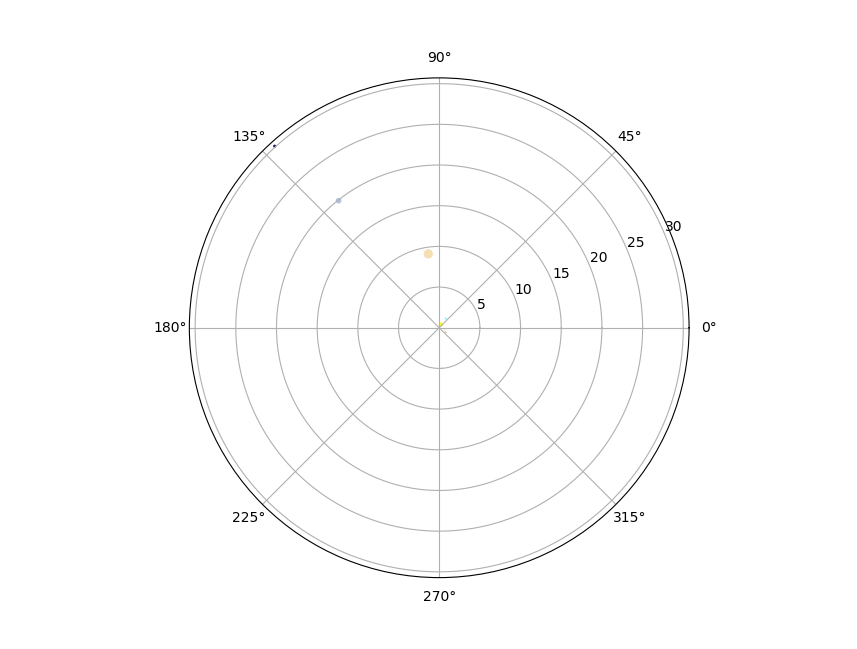

In [346]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_rmax(radii[-1])
scat = ax.scatter(positions, radii, c=colors, s=sizes)

In [71]:
# The Computer Language Benchmarks Game
# http://benchmarksgame.alioth.debian.org/
#
# originally by Kevin Carson
# modified by Tupteq, Fredrik Johansson, and Daniel Nanz
# modified by Maciej Fijalkowski
# 2to3

import sys 

def combinations(l):
    result = []
    for x in range(len(l) - 1):
        ls = l[x+1:]
        for y in ls:
            result.append((l[x],y))
    return result

def advance(dt, n, bodies, pairs):

    for i in range(n):
        for (([x1, y1, z1], v1, m1),
                ([x2, y2, z2], v2, m2)) in pairs:
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            mag = dt * ((dx * dx + dy * dy + dz * dz) ** (-1.5))
            b1m = m1 * mag
            b2m = m2 * mag
            v1[0] -= dx * b2m
            v1[1] -= dy * b2m
            v1[2] -= dz * b2m
            v2[0] += dx * b1m
            v2[1] += dy * b1m
            v2[2] += dz * b1m
        for (r, [vx, vy, vz], m) in bodies:
            r[0] += dt * vx
            r[1] += dt * vy
            r[2] += dt * vz


def report_energy(bodies, pairs):

    e = 0.0

    for (((x1, y1, z1), v1, m1),
            ((x2, y2, z2), v2, m2)) in pairs:
        dx = x1 - x2
        dy = y1 - y2
        dz = z1 - z2
        e -= (m1 * m2) / ((dx * dx + dy * dy + dz * dz) ** 0.5)
    for (r, [vx, vy, vz], m) in bodies:
        e += m * (vx * vx + vy * vy + vz * vz) / 2.
    print("%.9f" % e)

def offset_momentum(ref, bodies):

    px = py = pz = 0.0

    for (r, [vx, vy, vz], m) in bodies:
        px -= vx * m
        py -= vy * m
        pz -= vz * m
    (r, v, m) = ref
    v[0] = px / m
    v[1] = py / m
    v[2] = pz / m

def main(n, bodies=BODIES, ref='sun'):
    system = list(bodies.values())
    pairs = combinations(system)
    offset_momentum(bodies[ref], system)
    report_energy(system, pairs)
    advance(0.01, n, system, pairs)
    report_energy(system, pairs)

if __name__ == '__main__':
    main(500000)

-0.169075164
-0.169096567


In [398]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.lines import Line2D
%matplotlib notebook

PI = 3.14159265358979323
SOLAR_MASS = 4 * PI * PI
DAYS_PER_YEAR = 365.24

BODIES = {
        'sun': ([0.0, 0.0, 0.0], [0.0, 0.0, 0.0], SOLAR_MASS),

        'jupiter': ([4.84143144246472090e+00,
            -1.16032004402742839e+00,
            -1.03622044471123109e-01],
            [1.66007664274403694e-03 * DAYS_PER_YEAR,
                7.69901118419740425e-03 * DAYS_PER_YEAR,
                -6.90460016972063023e-05 * DAYS_PER_YEAR],
            9.54791938424326609e-04 * SOLAR_MASS),

        'saturn': ([8.34336671824457987e+00,
            4.12479856412430479e+00,
            -4.03523417114321381e-01],
            [-2.76742510726862411e-03 * DAYS_PER_YEAR,
                4.99852801234917238e-03 * DAYS_PER_YEAR,
                2.30417297573763929e-05 * DAYS_PER_YEAR],
            2.85885980666130812e-04 * SOLAR_MASS),

        'uranus': ([1.28943695621391310e+01,
            -1.51111514016986312e+01,
            -2.23307578892655734e-01],
            [2.96460137564761618e-03 * DAYS_PER_YEAR,
                2.37847173959480950e-03 * DAYS_PER_YEAR,
                -2.96589568540237556e-05 * DAYS_PER_YEAR],
            4.36624404335156298e-05 * SOLAR_MASS),

        'neptune': ([1.53796971148509165e+01,
            -2.59193146099879641e+01,
            1.79258772950371181e-01],
            [2.68067772490389322e-03 * DAYS_PER_YEAR,
                1.62824170038242295e-03 * DAYS_PER_YEAR,
                -9.51592254519715870e-05 * DAYS_PER_YEAR],
            5.15138902046611451e-05 * SOLAR_MASS) 
        }

class SolarSystem:
    def __init__(self, bodies=BODIES, dt=0.01):
        self.bodies = bodies
        self.dt = dt
        self.combinations = self._combinations()
        self.offset_momentum = self._offset_momentum(ref='sun')
        
    def _combinations(self):
        bodies = list(self.bodies.values())
        result = [] # use lists to make the iterators faster in cython
        for x in range(len(bodies) - 1):
            next_body = bodies[x+1:]
            for y in next_body:
                result.append((bodies[x], y))
        return result
    
    def _offset_momentum(self, ref='sun'):
        ref = self.bodies[ref]
        px = py = pz = 0.0

        for (r, [vx, vy, vz], m) in list(self.bodies.values()):
            px -= vx * m
            py -= vy * m
            pz -= vz * m
        (r, v, m) = ref
        v[0] = px / m
        v[1] = py / m
        v[2] = pz / m
        
    def _propagate(self):
        bodies = self.bodies
        combinations = self.combinations
        while True:
            for (([x1, y1, z1], v1, m1),
                    ([x2, y2, z2], v2, m2)) in combinations:
                dx = x1 - x2
                dy = y1 - y2
                dz = z1 - z2
                mag = self.dt * ((dx * dx + dy * dy + dz * dz) ** (-1.5))
                b1m = m1 * mag
                b2m = m2 * mag
                v1[0] -= dx * b2m
                v1[1] -= dy * b2m
                v1[2] -= dz * b2m
                v2[0] += dx * b1m
                v2[1] += dy * b1m
                v2[2] += dz * b1m
            for (r, [vx, vy, vz], m) in list(bodies.values()):
                r[0] += self.dt * vx
                r[1] += self.dt * vy
                r[2] += self.dt * vz
            yield combinations, bodies
            
    def _update_plot(self, i):
        """Calls the _propagate generator and updates the scatter plot self.scat"""
        self.combinations, selfbodies = next(self._propagate())
        positions = np.array([body[1][0] for body in self.bodies.items()])
        self.scat.set_offsets(*positions.T)
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
            
    def _plot(self):
        """Initial drawing of the scatter plot."""
        combinations, bodies = next(self._propagate())
        positions = np.array([body[1][0] for body in bodies.items()])
        self.scat = self.ax.scatter3D(*positions.T, c=self.colors, s=self.sizes, marker='o', alpha=1)
        self.legend_elements = [Line2D([0], [0], marker='o', color=c, label=n) for c, n in zip(self.colors, self.names)]
        self.ax.legend(handles=legend_elements, loc='upper right')
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
            
    def run_with_plot(self):
        """Runs the sim and plots stuff."""
        self.colors =['yellow', 'darkorange', 'wheat', 'lightsteelblue', 'midnightblue']
        self.sizes = np.array([body[1][2] * 10 if i ==0 else body[1][2] * 1000 for i, body in enumerate(self.bodies.items())])
        self.markers = ['o', 'o', '8', 'o', 'o']
        self.names = np.array([body[0] for body in self.bodies.items()])
        self.fig = plt.figure(figsize=plt.figaspect(0.5))
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.set_xlim3d([-35, 35])
        self.ax.set_ylim3d([-55, 55])
        self.ax.set_zlim3d([-5, 5])
        self.ani = animation.FuncAnimation(self.fig, func=self._update_plot,
                                           interval=5, init_func=self._plot, blit=True)
        
    def advance(self):
        self.combinations, self.bodies = next(self._propagate())
            
    def plot_current(self):
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim3d([-16, 16])
        ax.set_ylim3d([-25, 25])
        ax.set_zlim3d([-1, 1])
        colors = ['yellow', 'darkorange', 'wheat', 'lightsteelblue', 'midnightblue']
        positions = np.array([body[1][0] for body in self.bodies.items()])
        sizes = np.array([body[1][2] * 10 if i ==0 else body[1][2] * 1000 for i, body in enumerate(self.bodies.items())])
        names = np.array([body[0] for body in self.bodies.items()])
        ax.scatter3D(*positions.T, c=colors, s=sizes, marker='o', alpha=1)
        legend_elements = [Line2D([0], [0], marker='o', color=c, label=n) for c, n in zip(colors, names)]
        ax.legend(handles=legend_elements, loc='upper right')

Traceback (most recent call last):
  File "/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [399]:
sol = SolarSystem(dt=5)

<IPython.core.display.Javascript object>


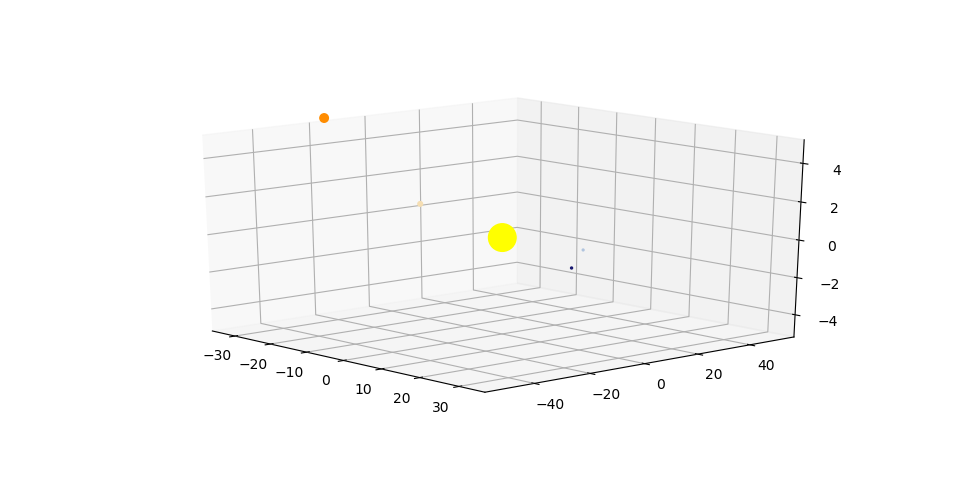

In [402]:
sol.run_with_plot()

[12.894369562139131, -15.111151401698631, -0.22330757889265573]


<IPython.core.display.Javascript object>


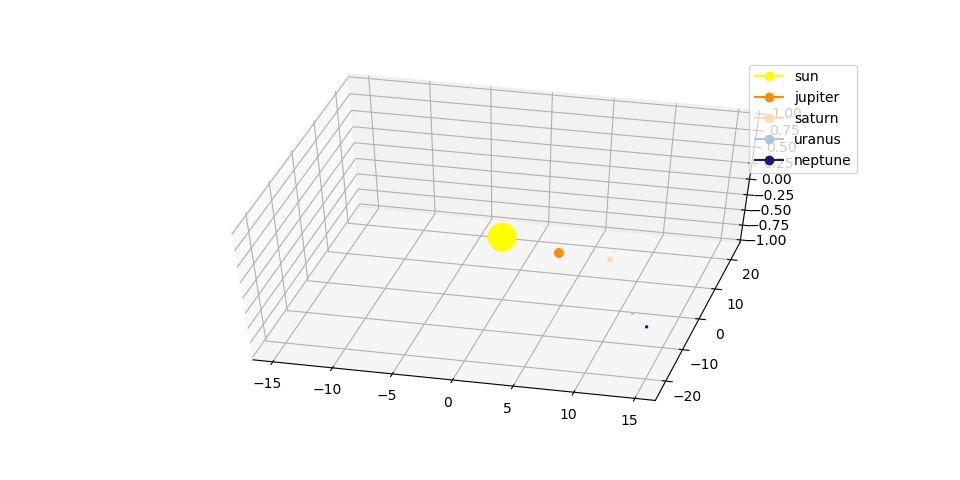

In [364]:
print(sol.bodies['uranus'][0])
sol.plot_current()

In [375]:
for i in range(30):
    sol.advance()

[19.54248705790436, -1.5583743572760183, -0.25871159600770666]


<IPython.core.display.Javascript object>


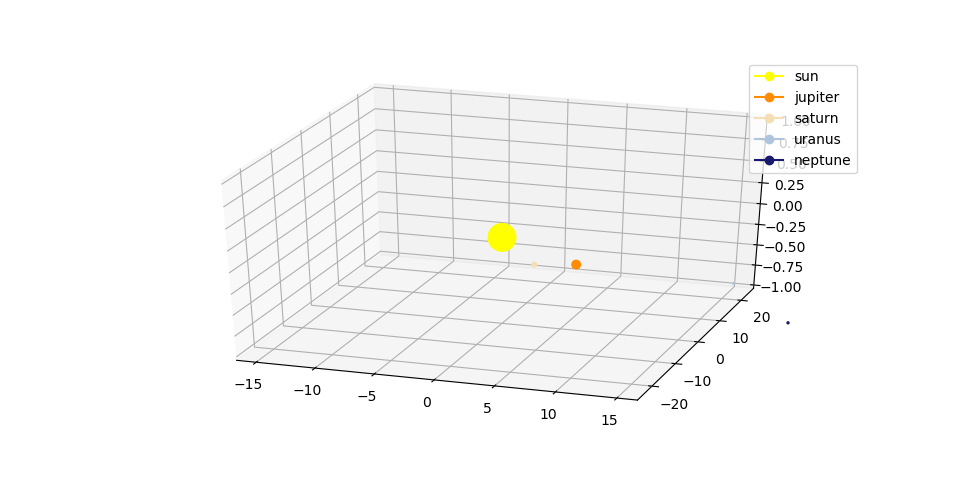

In [376]:
print(sol.bodies['uranus'][0])
sol.plot_current()

<IPython.core.display.Javascript object>


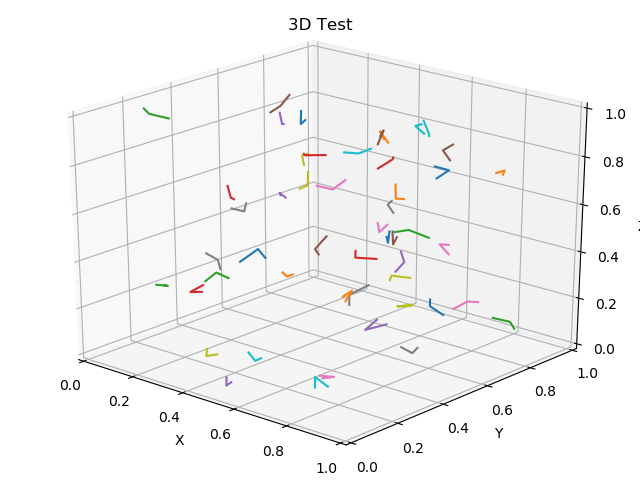

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


def Gen_RandLine(length, dims=2):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index - 1] + step

    return lineData


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Fifty lines of random 3-D lines
data = [Gen_RandLine(25, 3) for index in range(50)]

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 25, fargs=(data, lines),
                                   interval=50, blit=False)

plt.show()

In [ ]:
def _propagate(self):
    """Uses generator to propagate the state."""
    pos = self.positions
    forces = self.forces
    velocities = self.velocities
    accelerations = self.accelerations
    potentials = self.potentials
    t = self.time
    f = self.frame
    while True:
        pos = self.pbc(pos + self.velocities * self.dt + 0.5 * self.accelerations * self.dt ** 2, self.boundaries)
        velocities = accelerations * self.dt
        forces, accelerations, potentials= self.calc_pot_force_accel(pos,
                                                                     self.masses,
                                                                     self.lj.potential,
                                                                     self.lj.lj_force,
                                                                     nstlist=self.neighbor_list)
        t += self.dt
        f += 1
        yield pos, velocities, accelerations, forces, potentials, t, f

def _update_plot(self, i):
    """Calls the _propagate generator and updates the scatter plot self.scat"""
    data, velocities, accelerations, forces, potentials, t, f = next(self.traj)
    # Set x and y data...
    self.scat.set_offsets(data)
    # We need to return the updated artist for FuncAnimation to draw..
    # Note that it expects a sequence of artists, thus the trailing comma.
    return self.scat,

def _plot(self):
    """Initial drawing of the scatter plot."""
    pos, velocities, accelerations, forces, potentials, t, f = next(self.traj)
    self.scat = self.ax.scatter(*pos.T, s=150, edgecolor="k")
    self.ax.axis([-self.boundaries, self.boundaries, -self.boundaries, self.boundaries])
    # For FuncAnimation's sake, we need to return the artist we'll be using
    # Note that it expects a sequence of artists, thus the trailing comma.
    return self.scat,

def run_with_plot(self):
    """Runs the sim and plots stuff."""
    self.neighbor_list = False
    self.fig, self.ax = plt.subplots()
    self.ani = animation.FuncAnimation(self.fig, func=self._update_plot,
                                       interval=5, init_func=self._plot, blit=True)

## Spectral norm

Here's another project I have in python and cython code. If this gets to mathematical for you, you can simply pick another topic from this notebook.

In this project I want to recreate np.linalg.norm() of a square matrix, without using numpy. I start with an introduction to the problem, the python code, the cython code and then the simple NumPy one-liner.

We start with the n$\times$n matrix $\boldsymbol{A}$

\begin{equation}
\boldsymbol{A} =
\begin{bmatrix}
1/1 & 1/2 & 1/4 & 1/7 & \dots\\
1/3 & 1/5 & 1/8 & & \\
1/6 & 1/9 &     & & \\
1/10 & & \ddots & & \\
\vdots
\end{bmatrix}
\end{equation}

which can be computed using the `A(i, j)` function.

### Numpy

Here's the spectral norm computed using NumPy

In [20]:
import numpy as np
def A(i, j):
    """Returns value of square matrix A at position i, j."""
    return 1.0 / (((i + j) * (i + j + 1) >> 1) + i + 1)
a = [[A(i, j) for i in range(6)] for j in range(6)]
a = np.array(a)

# easiest way. Tell numpy to compute the l2 norm of A
print(np.linalg.norm(a, ord=2))

# here's how its done.
# Multiple A.T with A, get the greatest eigenvalue and take its square root
b = np.matmul(a.T, a)
eigvals = np.linalg.eigvalsh(b)
print(eigvals)
max_eigval = eigvals.max()
print(np.sqrt(max_eigval))

1.265778614975405
[1.77614193e-15 7.09101001e-11 1.28481612e-08 2.95156612e-05
 1.09237499e-02 1.60219550e+00]
1.2657786149754051


### Python

To find the eigenvectors of matrix $\boldsymbol{B} = \boldsymbol{A^H} \times \boldsymbol{A}$ I will use power iteration.

In [69]:
def matmul(a, b):
    i_max = len(a)
    j_max = len(b[0])
    result = [[0 for j in range(j_max)] for i in range(i_max)]
    for i in range(i_max):
        for j in range(j_max):
            for k in range(len(b)):
                result[i][j] += a[i][k] * b[k][j]
    return result

def power_iteration(A, num_simulations: int):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    if isinstance(A, list):
        A = np.array(A)
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)
        print(b_k1)
        break

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

a = [[A(i, j) for i in range(6)] for j in range(6)]
a = np.array(a)
eigvals = np.linalg.eigvalsh(b)
print(eigvals.max())

a = [[A(i, j) for i in range(n + 1)] for j in range(n + 1)]
a_t = [[A(j, i) for i in range(n + 1)] for j in range(n + 1)]
b = matmul(a_t, a)
eigvals = power_iteration(b, 9999999999999999999999999)

print('\n')
print(power_iteration(np.array([[0.5, 0.5], [0.2, 0.8]]), 10))
# print('\n')
# print(np.linalg.eigvalsh(np.array([[0.5, 0.5], [0.2, 0.8]])))

1.602195502129055
[0.87054886 0.32373988 0.17412583 0.11014539 0.07644817 0.05637146]


[0.68067594 0.62919762]
[0.76647314 0.59487874]


In [45]:
import random

def dot_product(a, b):
    assert len(a[0]) == len(b)
    out = []
    for i in range(len(b)):
        val = 0
        for j in range(len(a[i])):
            val += b[i] * a[i][j]
        out.append(val)
    return out

def power(A, num_iterations=10):
    # get a random vector of correct shape
    b_k = [random.random() for i in range(len(A))]
    for _ in range(num_iterations):
        b_k1 = dot_product(A, b_k)
        test = np.dot(A, b_k)
        print(b_k1, test)
        break
    
a = [[A(i, j) for i in range(n + 1)] for j in range(n + 1)]
a_t = [[A(j, i) for i in range(n + 1)] for j in range(n + 1)]
b = matmul(a_t, a)
test = np.array([[0.5, 0.5], [0.2, 0.8]])
power(test)

[0.004772012244993018, 0.6515585166840743] [0.32816526 0.52220122]


In [21]:
a = [[A(i, j) for i in range(6)] for j in range(6)]

def power_iteration(A, num_simulations: int):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(10):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

power_iteration(b, 10)

array([0.91574089, 0.3316558 , 0.17529961, 0.10950305, 0.07527943,
       0.05509246])

In [40]:
def power_iteration(A, num_simulations: int):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)
        print(b_k1)
        break

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

power_iteration(np.array([[0.5, 0.5], [0.2, 0.8]]), 10)

[0.3960266  0.18486839]


array([0.74795697, 0.04409624])

In [17]:
def A(i, j):
    """Returns value of square matrix A at position i, j."""
    return 1.0 / (((i + j) * (i + j + 1) >> 1) + i + 1)

def matmul(a, b):
    i_max = len(a)
    j_max = len(b[0])
    result = [[0 for j in range(j_max)] for i in range(i_max)]
    for i in range(i_max):
        for j in range(j_max):
            for k in range(len(b)):
                result[i][j] += a[i][k] * b[k][j]
    return result
    
def dot_product(a, b):
    return sum([a[i][0]*b[i] for i in range(len(b))] )
    
    
def power_iteration(A):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(100):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

def spectral_norm(n):
    a = [[A(i, j) for i in range(n + 1)] for j in range(n + 1)]
    a_t = [[A(j, i) for i in range(n + 1)] for j in range(n + 1)]
    b = matmul(a_t, a)
    print(b)
    eigval = power_iteration(np.array(b))
    return eigval
    
spectral_norm(5)

[[1.3450788760752235, 0.4845530801253308, 0.25519350720963624, 0.15898987525632263, 0.10907835051127734, 0.07969898921648474], [0.4845530801253308, 0.17903112233625426, 0.0958762969591284, 0.06045652013665878, 0.04185945250211359, 0.030807181765182046], [0.25519350720963624, 0.0958762969591284, 0.05190373014396134, 0.032982514767584806, 0.02297016968474936, 0.01698274322944674], [0.15898987525632263, 0.06045652013665878, 0.032982514767584806, 0.02107368641881961, 0.014736703070143381, 0.010930357139500418], [0.10907835051127734, 0.04185945250211359, 0.02297016968474936, 0.014736703070143381, 0.010336892028439683, 0.007685286396390191], [0.07969898921648474, 0.030807181765182046, 0.01698274322944674, 0.010930357139500418, 0.007685286396390191, 0.0057244736093056215]]


array([0.91574089, 0.3316558 , 0.17529961, 0.10950305, 0.07527943,
       0.05509246])

At some point, the required memory to store the array a will get very big. However, we can always use the `A(i, j)` function to get a value. We actually don't need to save a. Now we define some more functions which you don't need to understand. It would be nice that you notice that I am avoiding NumPy. I don't want NumPy to accelerate my calculations with its highly optimized code.

In [ ]:
def mat_times_vec(m, v, u=None):
    v_len = len(v)
    
    for i in range(v_len):
        partial_sum = 0
        for j in range(v_len):
            partial_sum += m[i][j] * u[j]
            

In [31]:
from array import array
from math import sqrt

def A(i, j):
    return 1.0 / (((i + j) * (i + j + 1) >> 1) + i + 1)

def A_times_u(u, v):
    u_len = len(u)

    for i in range(u_len):
        partial_sum = 0
        for j in range(u_len):
            partial_sum += A(i, j) * u[j]

        v[i] = partial_sum


def At_times_u(u, v):
    u_len = len(u)

    for i in range(u_len):
        partial_sum = 0
        for j in range(u_len):
            partial_sum += A(j, i) * u[j]

        v[i] = partial_sum


def B_times_u(u, out, tmp):
    A_times_u(u, tmp)
    At_times_u(tmp, out)


def spectral_norm(n):
    u = array("d", [1.0] * n)
    v = array("d", [0.0] * n)
    tmp = array("d", [0.0] * n)

    for _ in range(10):
        B_times_u(u, v, tmp)
        B_times_u(v, u, tmp)

    vBv = vv = 0

    for ue, ve in zip(u, v):
        vBv += ue * ve
        vv  += ve * ve

    return sqrt(vBv / vv)

In [32]:
%timeit spec_norm = spectral_norm(20) 

4.46 ms ± 87.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### cython

In [28]:
%%cython
from array import array
from math import sqrt

from cython cimport cdivision
from cython cimport boundscheck, wraparound
from cpython.array cimport array

@cdivision(True)
cdef inline double A(int i, int j):
    return 1.0 / (((i + j) * (i + j + 1) >> 1) + i + 1)

@boundscheck(False)
@wraparound(False)
cdef void A_times_u(double[::1] u, double[::1] v):
    cdef int i, j, u_len = len(u)
    cdef double partial_sum

    for i in range(u_len):
        partial_sum = 0
        for j in range(u_len):
            partial_sum += A(i, j) * u[j]
        v[i] = partial_sum


@boundscheck(False)
@wraparound(False)
cdef void At_times_u(double[::1] u, double[::1] v):
    cdef int i, j, u_len = len(u)
    cdef double partial_sum

    for i in range(u_len):
        partial_sum = 0
        for j in range(u_len):
            partial_sum += A(j, i) * u[j]
        v[i] = partial_sum


def B_times_u(u, out, tmp):
    A_times_u(u, tmp)
    At_times_u(tmp, out)


def spectral_norm_cy(n):
    u = array("d", [1.0] * n)
    v = array("d", [0.0] * n)
    tmp = array("d", [0.0] * n)

    for _ in range(10):
        B_times_u(u, v, tmp)
        B_times_u(v, u, tmp)

    vBv = vv = 0

    for ue, ve in zip(u, v):
        vBv += ue * ve
        vv  += ve * ve

    return sqrt(vBv / vv)

In [33]:
%timeit spectral_norm_cy(5)

14.5 µs ± 96.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## cython and further C dependencies

The great advantage of pyximport is that it not only checks, whether the source .pyx file has been changed but also if any dependencies within that source file have been changed (regardless of any changes to the .pyx file). These dependencies are tracked in a file with the .pyxdeps extension and the same name as the base .pyx file. The file definitions in this file can also be glob patterns.

Here's an example using C:

First we define a function in lib/examples.c

In [ ]:
%%writefile lib/examples.c
#include <stdio.h>
#include <string.h>
#include "examples.h"

double fibby(const int n)
{
  int i;
  double tmp, a=0.0, b=1.0;
  for ( i = 0; i < n; i++)
  {
    tmp = a + b;
    b = a;
    a = tmp;
  }
  return a;
  // printf("Your fibonacci number is: %f\n", a);
}

The packed C library will be compiled from the examples.h header file. In the header file we need to point to the fibby function defined in examples.c

In [ ]:
%%writefile lib/examples.h
#ifndef EXAMPLES_H
#define EXAMPLES_H

double fibby(const int n);

#endif

**Create the library**

Now we create the library by either using the makefile I copied from somewhere and running:

```bash
$ cd lib/
$ make
```

or by executing this cell:

In [ ]:
%%bash
cd lib
gcc -c -fPIC examples.c examples.h # compile the source files without making them executable
# also, compilation without -c would not work, because no main function is defined in examples.c
ar rcs libexamples.a examples.o # make an archive out of the output. This archive can be imported to cython
# ls

The finished libary is in the libexamples.a file. We need a .pyx file that makes use of our fibby function. Here it is:

In [ ]:
%%writefile pyexamples.pyx
cdef extern from "examples.h":
    double fibby(const int n)

def c_wrapped_fib(n: int) -> None:
    out = fibby(n)
    print("Your fibonacci number is: ", out)

And we need a setup.py file to make distutils handle the compilation. Because we have an external dependency, we need to declare that in the setup.py file.

In [ ]:
%%writefile setup.py
from distutils.core import setup
from distutils.extension import Extension
from Cython.Build import cythonize

examples_extension = Extension(
    name="pyexamples",
    sources=["pyexamples.pyx"],
    libraries=["examples"],
    library_dirs=["lib"],
    include_dirs=["lib"]
)
setup(
    name="pyexamples",
    ext_modules=cythonize([examples_extension])
)

After executing the setup script we can use our fibby function.

In [ ]:
!python setup.py build_ext --inplace

In [ ]:
import pyexamples

In [ ]:
pyexamples.c_wrapped_fib(90)

## Do the same thing via pyximport

Pyximport can also shorten this pretty tedious task. Using pyximport, again, allows us to recompile everything anytime some changes are made to any file. For this we can use the same .pyx file already created called pyexamplex.pyx. However, we need to tell pyximport which files it needs to consider for the compilation process. Here we need to adjust the settings of distutils Extension() function. This function is added to a .pyxbld file which can be used py pyximport to get infos about all the files needed to compile that module. Let's also copy the pyxexamples.pyx file to fib_wrapped_C.pyx to get a clean slate.

In [ ]:
!cp pyexamples.pyx fib_wrapped_C.pyx

In [36]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7efd10cf32b0>)

In [ ]:
%%writefile fib_wrapped_C.pyxbld
def make_ext(modname, pyxfilename):
    from distutils.extension import Extension
    return Extension(
        name="fib_wrapped_C",
        sources=["fib_wrapped_C.pyx", "lib/examples.c"],
        include_dirs=[".", "lib"])

In [ ]:
import fib_wrapped_C

In [ ]:
fib_wrapped_C.c_wrapped_fib(90)

Let's change something in the examples.c file and see, if it has worked.

In [ ]:
%%writefile lib/examples.c
#include <stdio.h>
#include <string.h>
#include "examples.h"

double fibby(const int n)
{
  int i;
  double tmp, a=0.0, b=1.0;
  for ( i = 0; i < n; i++)
  {
    tmp = a * b; // changed to multiplication to see if pyximport is working
    b = a;
    a = tmp;
  }
  return a;
  // printf("Your fibonacci number is: %f\n", a);
}

In [ ]:
fib_wrapped_C.c_wrapped_fib(90)

I was promised, that pyximport will recognize the changes to the lib/examples.c file. Oh well. Maybe you will have more luck. ¯\\_( ツ )_/¯

# Cython compiler directives

Compiler directives are instruction that influence how cython code is compiled. They have to follow this syntax:

- Be at the very start of the file
- have a comment char '# '
- followed by 'cython:'
- multiple directives can be listed with commas

Example:

```cython
# cython nonecheck=True, boundscheck=False

cdef here_comes_a_func():
    func = lambda x" f"hello {x}"
    return func
```

A full list of compiler directives can be found here:

https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiler-directives

Important directives are:

- cdivision (True/False): If set to False, cython will adjust division expressions so that the remainder of division matches python's division. This is because C rounds towards 0 and python rounds towards infinity.
  - `>>> -1 % 5
     4` in python.
  - `-1 % 5
     -1` in C and C++.
  - cdivision set to true can also lead to unexpected behavior when division by zero occurs. Because C doesn't check beforehand if a division by zero will be performed, anything from crashes to corrupted data can happen.
- infer_types (True/False): Default is None and only safe (semantically unchanging variables) inferences are allowed. E.g. Using integers for variables used in arithmetic expressions can lead to overflow. This needs to be specifically requested.
- optimize.use_switch (True/False): Whether to translate chained python if-else statements to C switch statements.

# Python and Cython performance

## Why is python slow

The main advantage of python is its platform-independence. This independence was realized by including a python virtual machine that handles the task of translating the python bytecode generated from .py files into machine code that can be executed on the CPU of your computer. This versatility makes python slower compared to compiled languages that create platform-specific machine code (gcc does not even create bytcode from the source files and goes straight to machine code).

When you call a function from within python that has been declared, translated and compiled in/from a .pyx file, the python VM skips the translation of bytecode to machine code and goes straight to the correct lines of machine code from the compiled file. The translation of python code into C code is handled by the cython module. This gives us a speedup for free. All we have to do is rename the file into .pyx and do the compilation steps.

## Dynamic and static typing

However, the speedup can be greatly improved with **static typing**. Python is a dynamically typed language. This allows us to do fun stuff like adding integers to floats:

```python
>>> print(1 + 2.1)
3.1
```

Lower level programming languages (like C) are statically typed. Every variable needs to be declared with its datatype. The speedup when using static typing comes from the compilers optimizing the machine code for that specific datatype. A simple operation like `a + b` can become quite some time intensive. The interpreter asks for the datatype of a and b, the implementation of addition for the given datatypes, and calls this function. Inside the addition function the types of the variables might be casted to different types.

We can achieve a speedup in our python code by simply typing variables statically. For this we use the `cdef` keyword followed by the variable type and name:

```cython
cdef int i
```

The difference becomes apparent with the following snippet:

In [ ]:
a = [x+1 for x in range(12)]
b = a
print(a[3], b[3])
a[3] = 42.0
print(a[3], b[3])
a = 13
print(a, b[3])

The same command `b = a` in cython would *copy* the data and yield a result akin to this:

```cython
>>> a = [x+1 for x in range(12)]
>>> b = a
>>> a[3] = 42.0
>>> print(a[3], b[3])
4 42.0
```

Static defined ctypes in cython follow C coercion and casting rules.

```C
double x, y;
x = 3;            // implicitly conversion (coercion)
y = (double) 5;   // explicitly conversion (casting)
```

Static variables in cython can be declared in many ways:

```cython
def a_func():
    cdef int i=0, j, k
    cdef float price=20.0, margin
    
def another_func():
    cdef:
        int i
        int N=2000
```

To compare the speed of dynamically and statically typed variables we need to turn off cython's own type inference, which normally assumes good types for variables. We can do this with the @cython function decorator. All variables in this function are henceforth handled as python objects.

In [ ]:
def integrate(a, b, f):
    N = 2000
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

In [ ]:
%%timeit
f = lambda x: x + 5 # expected integral from 0 to 1 is 0.5 + 5 = 5.5
integral = integrate(0, 1, f)
f = lambda x: 5 + .5*x - 5*x**2 + 17*x**3 - .332*x**4 + 200*x**5 - 1000*x**6 + 0.00001*x**7# get a random polynomial
integral = integrate(0, 1, f)

In [ ]:
%%writefile dynamic_typed.pyx
cimport cython

@cython.infer_types(False)
def integrate(a, b, f):
    N = 2000
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

In [ ]:
import dynamic_typed

In [ ]:
%%timeit
f = lambda x: x + 5 # expected integral from 0 to 1 is 0.5 + 5 = 5.5
integral = dynamic_typed.integrate(0, 1, f)
f = lambda x: 5 + .5*x - 5*x**2 + 17*x**3 - .332*x**4 + 200*x**5 - 1000*x**6 + 0.00001*x**7# get a random polynomial
integral = dynamic_typed.integrate(0, 1, f)
# print(integral)

In [ ]:
%%writefile static_typed.pyx
def integrate(a, b, f):
    cdef int i
    cdef int N=2000
    cdef float dx, s=0.0
    dx = (b-a)/N
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

In [ ]:
import static_typed

In [ ]:
%%timeit
f = lambda x: x + 5 # expected integral from 0 to 1 is 0.5 + 5 = 5.5
integral = static_typed.integrate(0, 1, f)
f = lambda x: 5 + .5*x - 5*x**2 + 17*x**3 - .332*x**4 + 200*x**5 - 1000*x**6 + 0.00001*x**7# get a random polynomial
integral = static_typed.integrate(0, 1, f)
# print(integral)

## Automatic type inference

Cython can guess the types of variables automatically to make your code run faster. This is not always possible. Consider this function:

```cython
def automatic_inference():
    i = 1
    d = 2.0
    c = 3+4j
    r = i * d * c
    return r
```
Here, only the variable d is correctly set to C's double type. The rest are python objects. This slows down our code.

**Why are they python objects?**

- `i = 1` this could be `bint`, `short`, `int`, `long`. Not sure, so use python object to allow maximum compatibility.
- `c = 3+4j` could be `float complex` or `double complex`. Not sure. Use python object.
- `r = i * d * c` same here.

**Better type inference**

We can allow cython more leeway in deciding types with the same `@cython.infer_types` decorator.

```cython
cimport cython

@cython.infer_types(True)
def more_inference():
    i = 1
    d = 2.0
    c = 3+4j
    r = i * d + c
    return r
```

Now `i` is set to `long`, `d` is set to `double` and `c` and `r` are considered `double complex`. When infer_types is set to true, we have to make sure that our integers don't overflow. So make sure `i` never goes over 9223372036854775807, or you will end up with -9223372036854775808.

## Static type reference of python types

The built-in python types can also be statically defined. Here they are:

- `cdef list`
- `cdef dict`
- `cdef str`
- `cdef set`

Under the hood, cython makes these objects to C pointer to the binary data of a python `struct`. They can be used like ordinary python variables but stay constrained to their respective type.

In [ ]:
import struct
import binascii

values = (1, 'This is a string'.encode('utf-8'), 2.723)
s = struct.Struct('I 22s f') # len of str is 16 22s adds some \x00 ASCII NULLs
packed_data = s.pack(*values)
print(packed_data)

## Types of cython functions

Much of static and dynamic variables also applies to functions. C and python functions are pretty similar. Tehy have names, take zero or a number of arguments, and return new values. However, python functions are objects. They:

- have states
- can be created at import time or at runtime
- can be created anonymously (lambda)
- be returned from other functions
- passed as argument to other functions
- called with positional and keyworded arguments
- defined with default values

C functions have less overhead. They:

- can be passed as arguments to other C functions
- cannot be defined inside other functions
- their names are not modifiable
- take arguments only by position
- can't have default values

This results in python functions being orders of magnitude slower than C functions.

**First let's look at a pure python function**

In [9]:
def fact(n):
    """Computes factorial."""
    if n <= 1:
        return 1
    return n * fact(n - 1)
%timeit fact(20)

2.75 µs ± 31.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Def

**By just prepending the %%cython cell magic we can speed this function up significantly**

In [11]:
%load_ext cython

In [15]:
%%cython
def fact_cy(n):
    """Also computes factorial."""
    if n <= 1:
        return 1
    return n * fact_cy(n - 1)

In [16]:
%timeit fact_cy(20)

845 ns ± 2.44 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### cdef

**Let's make it even faster by telling cython: Don't use dynamic python functions, use C integers and change the recursive function to a loop**

We need to wrap the c_fact() function with a small python function (wrap_c_fact()) which calls it. 

In [39]:
%%cython
cdef long c_fact(long n):
    """Computes factorial very fast."""
    if n <= 1:
        return 1
    return n * c_fact(n - 1)

def wrap_c_fact(n):
    return c_fact(n)

In [41]:
%timeit wrap_c_fact(20)

74.5 ns ± 3.81 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


**Some drawbacks:**

cdef functions are restricted to C types and thus would give erroneous results for c_fact(21) because of integer overflow.

### cpdef

cpdef functions combine the accessibility of def functions with the performance of cdef functions.
With the `inline` keyword we can tell the compiler to replace the function with its body, whenever it is called, thus removing the last bit of overhead which arises from multiple function calls. That's basically how fast it gets.

In [44]:
%%cython
cpdef inline long cp_fract(long n):
    if n <= 1:
        return 1
    return n * cp_fract(n - 1)

In [45]:
%timeit cp_fract(20)

72.3 ns ± 0.791 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Faster for loops

Looping is very essential to programming. Here, cython needs some type info to accelerate your loops, also. Instead of writing:

```python
n = 100
for i in range(n):
    # ...
```
You can help cython to generate faster C loops by statically defining the variables. Here are some guidelines for fast loops:

When looping over a range() call give a C integer:
```cython
cdef int N
for i in range(N):
    # ...
```
This can only be used efficiently **if i is not used in the loop body**. If i is used in the loop body, you also need to declare it. But make sure, it does not overflow.

```cython
cdef int i, N
for i in range(N):
    data[i] = data[i] * 2
```
When looping over containers (`list`, `tuple`, `dict`,..) it is often advised to not do python-type looping, but use indexing:

This is slow:

```python
for i, a in enumerate(array[1:-1]):
    i += 1
    a[i] = (a[i - 1] + a[i] + a[i + 1]) / 3
```
This is fast:

```cython
cdef unsigned int i, n = len(a) - 1 # ignore the last element
for i in range(1, n): # ignore the 0th element
    a[i] = (a[i -1] + a[i] + a[i + 1]) / 3.0
```

## Compile time statements and declarations

You can use `DEF` declarations and `IF-ELIF-ELSE` statements to define recurring magic numbers or do conditional compilation:

```cython
DEF PI = 3.1416
DEF E = 2.7183

IF UNAME_SYSNAME == "Windows":
    # Run windows code
ELIF UNAME_SYSNAME == "Darwin":
    # Run Mac code
ELIF UNAME_SYSNAME == "Linux":
    # Run Linux code
ELSE:
    # Make me a spam sandwich
    
def some_func():
    return E ** PI
```

# Cython and NumPy

We have seen that cython can iterate over the built-in containers (`list`, `dict`, `tuple`,..) and make this task faster. However, this type of iteration is not fast enough. The problem is that the list is internally converted to a list of PyObjects. This type casting results in more overhead. However, CPUs are very optimized to work on lists/arrays of floats. That's all they're doing, basically. If we wan't to tap into these super fast calculations (like C++s `std::vector`). This is where python buffers come into play. Buffers can be used to expose an object's data in a byte-format. Python buffers is what NumPy uses to make your code run faster. With these buffers NumPy build contiguous arrays of boxed data. Because the dataypes are well defined, the calculations become more bare-bone and with that faster.

**NumPy can be used in cython**

Cython has support for python buffers and with that, also NumPy arrays. Again, to make cython run faster we need to fix the dtypes of our arrays.

In [11]:
%load_ext Cython

In [12]:
import numpy as np

In [25]:
%%cython

import numpy as np
DTYPE = np.intc

cdef int clip(int a, int min_value, int max_value):
    return min(max(a, min_value), max_value)

def compute(array_1, array_2, int a, int b, int c):

    # The "cdef" keyword is also used within functions to type variables. It
    # can only be used at the top indentation level (there are non-trivial
    # problems with allowing them in other places, though we'd love to see
    # good and thought out proposals for it).
    cdef Py_ssize_t x_max = array_1.shape[0]
    cdef Py_ssize_t y_max = array_1.shape[1]

    assert array_1.shape == array_2.shape
    assert array_1.dtype == DTYPE
    assert array_2.dtype == DTYPE

    result = np.zeros((x_max, y_max), dtype=DTYPE)

    # It is very important to type ALL your variables. You do not get any
    # warnings if not, only much slower code (they are implicitly typed as
    # Python objects).
    # For the "tmp" variable, we want to use the same data type as is
    # stored in the array, so we use int because it correspond to np.intc.
    # NB! An important side-effect of this is that if "tmp" overflows its
    # datatype size, it will simply wrap around like in C, rather than raise
    # an error like in Python.

    cdef int tmp

    # Py_ssize_t is the proper C type for Python array indices.
    cdef Py_ssize_t x, y

    for x in range(x_max):
        for y in range(y_max):

            tmp = clip(array_1[x, y], 2, 10)
            tmp = tmp * a + array_2[x, y] * b
            result[x, y] = tmp + c

    return result

In [26]:
array_1 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
array_2 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
a = 4
b = 3
c = 9

In [30]:
%%timeit
result = compute(array_1, array_2, a, b, c)

11.8 s ± 44.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can also use the `cpdef` function declaration to squeeze some more performance out of this thing.

In [31]:
%%cython
from numpy cimport ndarray
import numpy as np
DTYPE = np.intc

cdef int clip(int a, int min_value, int max_value):
    return min(max(a, min_value), max_value)

cpdef ndarray compute_cpdef(array_1, array_2, int a, int b, int c):

    # The "cdef" keyword is also used within functions to type variables. It
    # can only be used at the top indentation level (there are non-trivial
    # problems with allowing them in other places, though we'd love to see
    # good and thought out proposals for it).
    cdef Py_ssize_t x_max = array_1.shape[0]
    cdef Py_ssize_t y_max = array_1.shape[1]

    assert array_1.shape == array_2.shape
    assert array_1.dtype == DTYPE
    assert array_2.dtype == DTYPE

    result = np.zeros((x_max, y_max), dtype=DTYPE)

    # It is very important to type ALL your variables. You do not get any
    # warnings if not, only much slower code (they are implicitly typed as
    # Python objects).
    # For the "tmp" variable, we want to use the same data type as is
    # stored in the array, so we use int because it correspond to np.intc.
    # NB! An important side-effect of this is that if "tmp" overflows its
    # datatype size, it will simply wrap around like in C, rather than raise
    # an error like in Python.

    cdef int tmp

    # Py_ssize_t is the proper C type for Python array indices.
    cdef Py_ssize_t x, y

    for x in range(x_max):
        for y in range(y_max):

            tmp = clip(array_1[x, y], 2, 10)
            tmp = tmp * a + array_2[x, y] * b
            result[x, y] = tmp + c

    return result

In [32]:
%%timeit
result = compute_cpdef(array_1, array_2, a, b, c)

12.1 s ± 79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, nice NumPy code is often the better option.

In [33]:
def compute_np(array_1, array_2, a, b, c):
    return np.clip(array_1, 2, 10) * a + array_2 * b + c

In [34]:
%%timeit
result = compute_np(array_1, array_2, a, b, c)

22.7 ms ± 674 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# A full cython development: Spectral Norm

With the python type `memoryview` we can get an idea how buffers are handled. `memoryiew` allows us to inspect the memory addresses of variables. Let's create a byte-type string and see how it's done.

(Info: A byte types string is a new python3 object which helps to separate the data of a string and its encoding.)

```python
>>> b'\xa420'.decode('iso-8859-15')
'€20'
```

In [1]:
bb = b"This is a byte type string, which is normally encoded using utf-8"
memv = memoryview(bb)
memv

Playing with this memv object can give us an idea how buffers work.

In [6]:
memv[0]

84

In [10]:
memv[:10][1]

104

# More compilation methods

**Reading and writing files in jupyter**

The other compilation methods rely on writing .pxy files to disk. Instead of opening these files your text editor of choice (Hint: There is a correct answer to the question "What is your favorite text editor" and emacs is not it.) let us open the .pyx files direclty in this notebook using cell magic.

## Distutils and Cythonize

`distutils` is a python standard package used for building, packing and distributing python projects. It can compile C source code into an extension module. How neat is that?! It manages all python versions, platforms and architectures. That's pretty neat. Cython's `cythonize()` function produces a .c file and `distutils` compiles it for us. This compilation pipeline requires us to write a short setup script. This compilation pipeline is the most common way to ditribute cython code.

Let's use the %load magic function to open the file helloworld.pyx

In [ ]:
%load helloworld.pyx
print(Hello World)

As you can probably guess, the quotation marks declaring 'Hello World' as a string are missing. Let's fix that using the %%writefile cell magic. Additionally we put the print statement in a function, so we can call it.

In [ ]:
%%writefile helloworld.pyx
def hello_world():
    """This is the docstring which gets transferred into the .so
    
    Additionally to printing hello world, I will also do some calculations.
    
    Args:
        No args lol.
        
    Returns:
        None
        
    """
    print("Hello World")

**The setup file**

A simple setup.py file is only a few lines long (most of them are imports). At the core you have the nested function call. The `cythonize()` function can take single files, list of files or glob patterns. The `cythonize()` function returns a list of distutils extension modules, that the setup function knows how to use. This setup.py file can be invoked from the command-line using:

```bash
$ python setup.py build_ext --inplace
```

In [ ]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("helloworld.pyx")
)

In [ ]:
!python setup.py build_ext --inplace

You see, that some files have appeared in your current directory. The helloworld.c file contains quite a few lines C code. But after compiling it, it is faster than python.

In [ ]:
count = len(open('helloworld.c').readlines())
print(count)

Now we can import stuff from our shared object.

In [ ]:
from helloworld import hello_world
print(help(hello_world))

In [ ]:
hello_world()

Although distutils is the quasi-standard for deploying cython there's a major drawback using distutils for development.

**:( :( :( :( :( :( :( :(**

Changes in .so files are not caught by the %autoreload extension, meaning if you change something in your cython code and recompile it, you have to restart the kernel.

## On-the-fly compilation with pyximport

pyximport retrofits the import statement to recognize .pyx extension modules. The pyximport module comes with cython and can easily be accessed via:

In [ ]:
import pyximport
pyximport.install()

In [ ]:
%%writefile fib.pyx
def fibonacci(int n):
    cdef int i
    cdef double a=0.0, b=1.0
    for i in range(n):
        a, b = a+b, a
    return a

With pyximport we can now import from .pyx files. In the background there is still the compilation pipeline going on, but we don't need to worry about that.

In [ ]:
import fib

In [ ]:
print(fib.__file__)
print(type(fib))

In [ ]:
%%time
fib.fibonacci(90)

# Organizing cython code

In normal python code is organized into packages. You have -packages for plotting (matpolotlib), or numerical caluclations (numpy). In these packages you have modules and submodules. A very common module of matplotlib is the matplotlib.pyplot module or the matplotlib.colors module. In the colors module you will find functions (rgb_to_hex) and classes (Normalize). This is how python code is organized

```python
>>> import matplotlib as mpl
>>> type(mpl.colors.Normalize)
type
>>> type(mpl.colors.rgb_to_hsv)
function
```

The same organization can be achieved with cython code. Cython modules can use functions from other cython modules. For this organization, cython has 3 filetypes. .pyx files are *implementation files*, .pxd are *definition files* and .pxi are *include files*. Together with these file extensions cython has the `cimport` statement to grant compile time access to C-level constructs. The .pxd files are searched for these constructs.

To show the inner workings of these different files we will write some code into different files. Let's say we want to do some simulations. We need a class to capture the current state. What follows is my rudimentary Lennard-Jones Argon simulation.

The state class uses some advanced python syntax. If you want to know more about the `yield` statement, or the `@staticmethod`, `@property`, and `@velocities.setter` method just ask me. :D

## Initialize the simulation

Here we generate random starting positions and instantiate the `State` 

In [ ]:
np.random.seed(1)
positions = (np.random.rand(20, 2) * 20 - 10) * 1e-10
# due to the large integrator step of 1000fs, neighbors will be calculated every step
sim = State(positions, velocities='boltzmann', dt=1, nststep=5, boundaries=10e-10)
print(sim)

In [ ]:
plt.close('all')
sim.run_with_plot()

How this class is not important right now, and I am sure, there are still some Errors in there. It is important to see, that the `State` class uses two classes (`Parameters`, and `LJ`) in itself. At the very bottom there also is the `run()` function.

In [3]:
a = [1, 2 ,3]
id(a)

139625768519688

In [4]:
import ctypes

In [6]:
ctypes.cast(139625768519688, ctypes.py_object).value

[1, 2, 3]

In [1]:
import array

In [ ]:
array.array()

# Other stuff

## Python

A simple python function to print a certain number of prime numbers. I got a time of 30.7 ms ± 300 µs for for 1000 prime numbers.

In [1]:
def primes_python(nb_primes):
    if nb_primes > 1000:
        nb_primes = 1000
      
    p = list(range(100000)) # number space for checking
    len_p = 0  # The current number of elements in p.
    n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1
        
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

In [22]:
%%timeit
primes = primes_python(1000)

30.7 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cython

By simply saving the function to a .pyx file and compile it with cython we can save a great amount of time.

In [23]:
%%writefile prime_numbers.pyx
def primes_cython(nb_primes):
    if nb_primes > 1000:
        nb_primes = 1000
      
    p = list(range(100000)) # number space for checking
    len_p = 0  # The current number of elements in p.
    n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1
        
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

Overwriting prime_numbers.pyx


In [24]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("prime_numbers.pyx")
)

Overwriting setup.py


In [25]:
!python setup.py build_ext --inplace

Compiling prime_numbers.pyx because it changed.
[1/1] Cythonizing prime_numbers.pyx
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/kevin/projects/accelerate_python_code/prime_numbers.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'prime_numbers' extension
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -m64 -fPIC -m64 -fPIC -fPIC -I/home/kevin/.conda/envs/work_3/include/python3.6m -c prime_numbers.c -o build/temp.linux-x86_64-3.6/prime_numbers.o
gcc -pthread -shared -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed build/temp.linux-x86_64-3.6/prime_numbers.o -L/home/kevin/.conda/envs/work_3/lib -lpython3.6m -o 

In [28]:
import os
os.listdir()

['.ipynb_checkpoints',
 'vmdscene.obj',
 'vmdscene.mtl',
 'accelerate_python_code.ipynb',
 'accelerate_python_code.pdf',
 'helloworld.pyx',
 'helloworld.c',
 'helloworld.cpython-36m-x86_64-linux-gnu.so',
 'setup.py',
 'build',
 'prime_numbers.pyx',
 'prime_numbers_cdef.pyx',
 'prime_numbers_cdef.c',
 'prime_numbers_cdef.cpython-36m-x86_64-linux-gnu.so',
 'prime_numbers.c',
 '.nfs000000000b7a973100015283',
 'prime_numbers.cpython-36m-x86_64-linux-gnu.so']

**Importing from shared objects is 

In [6]:
from prime_numbers import primes_cython

In [7]:
%%time
primes = primes_cython(1000)
print(primes[::4])

[2, 11, 23, 41, 59, 73, 97, 109, 137, 157, 179, 197, 227, 241, 269, 283, 313, 347, 367, 389, 419, 439, 461, 487, 509, 547, 571, 599, 617, 643, 661, 691, 727, 751, 773, 811, 829, 859, 883, 919, 947, 977, 1009, 1031, 1051, 1087, 1103, 1129, 1171, 1201, 1229, 1259, 1289, 1303, 1327, 1381, 1427, 1447, 1471, 1489, 1523, 1553, 1579, 1607, 1621, 1663, 1697, 1723, 1753, 1787, 1823, 1867, 1879, 1913, 1951, 1993, 2011, 2039, 2081, 2099, 2131, 2153, 2207, 2239, 2269, 2293, 2333, 2351, 2381, 2399, 2437, 2467, 2521, 2549, 2591, 2621, 2659, 2683, 2699, 2719, 2749, 2789, 2803, 2843, 2879, 2909, 2953, 2971, 3019, 3049, 3083, 3121, 3169, 3203, 3229, 3259, 3307, 3329, 3359, 3389, 3433, 3463, 3499, 3529, 3547, 3581, 3613, 3637, 3673, 3701, 3733, 3769, 3803, 3847, 3877, 3911, 3929, 3967, 4007, 4027, 4073, 4099, 4133, 4159, 4217, 4241, 4261, 4289, 4339, 4373, 4421, 4451, 4483, 4517, 4549, 4591, 4637, 4651, 4679, 4723, 4759, 4793, 4817, 4877, 4919, 4943, 4969, 4999, 5021, 5059, 5099, 5119, 5171, 5209, 5237,

## Cython with C-types

In [8]:
%%writefile prime_numbers_cdef.pyx
def primes_cython_cdef(int nb_primes):
    cdef int n, i, len_p
    cdef int p[1000]
    if nb_primes > 1000:
        nb_primes = 1000

    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1

    # Let's return the result in a python list:
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

Writing prime_numbers_cdef.pyx


In [9]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("prime_numbers_cdef.pyx")
)

Overwriting setup.py


In [10]:
!python setup.py build_ext --inplace

Compiling prime_numbers_cdef.pyx because it changed.
[1/1] Cythonizing prime_numbers_cdef.pyx
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/kevin/projects/accelerate_python_code/prime_numbers_cdef.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'prime_numbers_cdef' extension
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -m64 -fPIC -m64 -fPIC -fPIC -I/home/kevin/.conda/envs/work_3/include/python3.6m -c prime_numbers_cdef.c -o build/temp.linux-x86_64-3.6/prime_numbers_cdef.o
gcc -pthread -shared -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed build/temp.linux-x86_64-3.6/prime_numbers_cdef.o -L/home/kevin/.con

In [14]:
from prime_numbers_cdef import primes_cython_cdef

In [16]:
%%time
primes = primes_cython_cdef(1000)
print(primes[::4])

[2, 11, 23, 41, 59, 73, 97, 109, 137, 157, 179, 197, 227, 241, 269, 283, 313, 347, 367, 389, 419, 439, 461, 487, 509, 547, 571, 599, 617, 643, 661, 691, 727, 751, 773, 811, 829, 859, 883, 919, 947, 977, 1009, 1031, 1051, 1087, 1103, 1129, 1171, 1201, 1229, 1259, 1289, 1303, 1327, 1381, 1427, 1447, 1471, 1489, 1523, 1553, 1579, 1607, 1621, 1663, 1697, 1723, 1753, 1787, 1823, 1867, 1879, 1913, 1951, 1993, 2011, 2039, 2081, 2099, 2131, 2153, 2207, 2239, 2269, 2293, 2333, 2351, 2381, 2399, 2437, 2467, 2521, 2549, 2591, 2621, 2659, 2683, 2699, 2719, 2749, 2789, 2803, 2843, 2879, 2909, 2953, 2971, 3019, 3049, 3083, 3121, 3169, 3203, 3229, 3259, 3307, 3329, 3359, 3389, 3433, 3463, 3499, 3529, 3547, 3581, 3613, 3637, 3673, 3701, 3733, 3769, 3803, 3847, 3877, 3911, 3929, 3967, 4007, 4027, 4073, 4099, 4133, 4159, 4217, 4241, 4261, 4289, 4339, 4373, 4421, 4451, 4483, 4517, 4549, 4591, 4637, 4651, 4679, 4723, 4759, 4793, 4817, 4877, 4919, 4943, 4969, 4999, 5021, 5059, 5099, 5119, 5171, 5209, 5237,

# Reloading cython

Cython is a little bit complicated when it comes to reloading the compiled .so files.

# Import C and C++ code (chapter 7 and 8 from book)

# Convert to pdf

To build this pdf you need to have jupyter extensions installed. Either with pip:

```bash
$ pip install jupyter_contrib_nbextensions
```

or with conda:

```bash
$ conda install -c conda-forge jupyter_contrib_nbextensions
```

To convert the notebook into a pdf you can execute:

```bash
$ jupyter nbconvert --to pdf accelerate_python_code.ipynb
```

### Errors
These errors might occur when you try to convert this notebook into a pdf:

**Permissions to a shared object**

If you get an error, because python does not have permissions to some shared object execute this:

```bash
$ export LD_LIBRARY_PATH=/home/kevin/.conda/envs/work_3/lib:$LD_LIBRARY_PATH
```
**Wrong kernelspec**

If you get an error, because conda doesn't know the kernel open the notebook file in a texteditor and change the kernel name by hand.

```json
 "metadata": {
  "kernelspec": {
   "display_name": "work_3",
   "language": "python",
   "name": "nb-conda-faster_py_env-py"
```

will be changed to:

```json
 "metadata": {
  "kernelspec": {
   "display_name": "work_3",
   "language": "python",
   "name": "faster_py_env"
```

In [3]:
!jupyter nbconvert --to pdf accelerate_python_code.ipynb

[NbConvertApp] Converting notebook accelerate_python_code.ipynb to pdf
[NbConvertApp] Writing 24118 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 32661 bytes to accelerate_python_code.pdf
